# `AbsorptionModel` Tutorial

Trey V. Wenger (c) April 2025

Here we demonstrate the basic features of the `AbsorptionModel` model. `AbsorptionModel` models 21-cm `1-exp(-optical depth)` spectra like those obtained from typical HI absorption observations.

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import caribou_hi
print("caribou_hi version:", caribou_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.22.0
arviz version: 0.22.0dev
bayes_spec version: 1.7.8
caribou_hi version: 2.0.1+0.g9e7964e.dirty


## Simulating Data

To test the model, we must simulate some data. We can do this with `AbsorptionModel`, but we must pack a "dummy" data structure first. The model expects the observation to be named `"absorption"`.

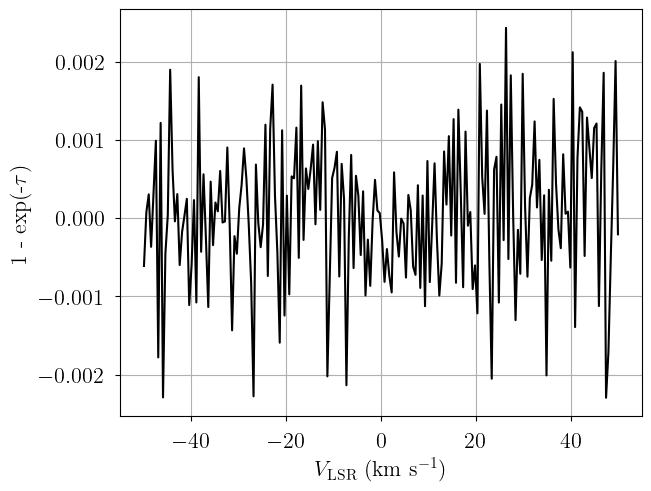

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = np.linspace(-50.0, 50.0, 200) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms = 0.001 # 1 - exp(-tau)

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
absorption = rms * np.random.randn(len(velo_axis))

dummy_data = {"absorption": SpecData(
    velo_axis,
    absorption,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"1 - exp(-$\tau$)",
)}

# Plot dummy data
fig, ax = plt.subplots(layout="constrained")
ax.plot(dummy_data["absorption"].spectral, dummy_data["absorption"].brightness, "k-")
ax.set_xlabel(dummy_data["absorption"].xlabel)
_ = ax.set_ylabel(dummy_data["absorption"].ylabel)

Now that we have a dummy data format, we can generate a simulated observation by evaluating the model. First we create the model.

In [3]:
from caribou_hi import AbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
model = AbsorptionModel(
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total=10.0, # total optical depth prior width (km s-1)
    prior_tkin_factor=[2.0, 2.0], # kinetic temperature prior shape
    prior_fwhm2=500.0, # FWHM^2 prior width (km2 s-2)
    prior_log10_nHI=[0.0, 1.5],  # log10(density) prior mean and width (cm-3)
    prior_velocity=[0.0, 10.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 2.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_fwhm_L=None,  # Assume Gaussian line profile
    prior_baseline_coeffs=None,  # Default baseline priors
)
model.add_likelihood()

Now we simulate with a given set of simulation parameters.

In [4]:
from caribou_hi import physics

# Simulation parameters
log10_nHI = np.array([1.25, 0.0, -0.5])
tkin = np.array([50.0, 300.0, 5000.0])
log10_n_alpha = np.array([-5.0, -6.0, -7.0])
depth = np.array([5.0, 25.0, 300.0])
nth_fwhm_1pc = np.array([1.25, 1.75, 1.5])

tspin = physics.calc_spin_temp(tkin, 10.0**log10_nHI, 10.0**log10_n_alpha).eval()
print("tspin", tspin)

fwhm_nonthermal = physics.calc_nonthermal_fwhm(depth, nth_fwhm_1pc, 1/3)
fwhm2_thermal = physics.calc_thermal_fwhm2(tkin)
fwhm = np.sqrt(fwhm_nonthermal**2.0 + fwhm2_thermal)
print("fwhm", fwhm)

tkin_max = physics.calc_kinetic_temp(fwhm**2.0)
tkin_factor = tkin / tkin_max
print("tkin_factor", tkin_factor)

log10_Pth = np.log10(tkin) + log10_nHI
print("log10_Pth", log10_Pth)

log10_NHI = log10_nHI + np.log10(depth) + 18.489351
print("log10_NHI", log10_NHI)

tau_total = physics.calc_tau_total(10.0**log10_NHI, tspin)
print("tau_total", tau_total)

sim_params = {
    "tau_total": tau_total,
    "tkin": tkin,
    "tkin_factor": tkin_factor,
    "fwhm2": fwhm**2.0,
    "log10_nHI": log10_nHI,
    "velocity": np.array([-5.0, 5.0, 10.0]),
    "log10_n_alpha": log10_n_alpha,
    "baseline_absorption_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observation
absorption = model.model["absorption"].eval(sim_params, on_unused_input="ignore")
data = {"absorption": SpecData(
    velo_axis,
    absorption,
    rms,
    xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
    ylabel=r"1 - exp(-$\tau$)",
)}

tspin [  49.99731723  297.73994712 2378.08874354]
fwhm [ 2.61848013  6.31743379 18.15482461]
tkin_factor [0.33365144 0.34392316 0.69407669]
log10_Pth [2.94897    2.47712125 3.19897   ]
log10_NHI [20.438321   19.88729101 20.46647225]
tau_total [3.01108799 0.14216839 0.06754502]


In [5]:
sim_params

{'tau_total': array([3.01108799, 0.14216839, 0.06754502]),
 'tkin': array([  50.,  300., 5000.]),
 'tkin_factor': array([0.33365144, 0.34392316, 0.69407669]),
 'fwhm2': array([  6.85643822,  39.90996968, 329.5976568 ]),
 'log10_nHI': array([ 1.25,  0.  , -0.5 ]),
 'velocity': array([-5.,  5., 10.]),
 'log10_n_alpha': array([-5., -6., -7.]),
 'baseline_absorption_norm': [0.0],
 'tspin': array([  49.99731723,  297.73994712, 2378.08874354]),
 'log10_Pth': array([2.94897   , 2.47712125, 3.19897   ]),
 'log10_NHI': array([20.438321  , 19.88729101, 20.46647225]),
 'log10_depth': array([0.69897   , 1.39794001, 2.47712125])}

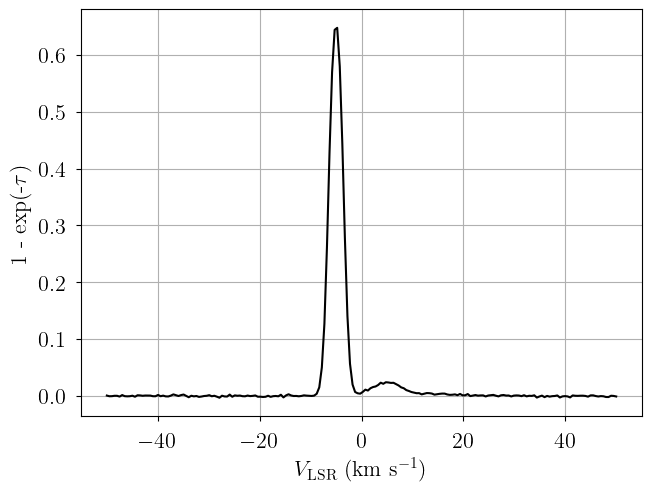

In [6]:
# Plot data
fig, ax = plt.subplots(layout="constrained")
ax.plot(data["absorption"].spectral, data["absorption"].brightness, "k-")
ax.set_xlabel(data["absorption"].xlabel)
_ = ax.set_ylabel(data["absorption"].ylabel)

## Model Definition

Finally, with our model definition and (simulated) data in hand, we can explore the capabilities of `AbsorptionModel`.

In [7]:
# Initialize and define the model
n_clouds = 3
model = AbsorptionModel(
    data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total=10.0, # total optical depth prior width (km s-1)
    prior_tkin_factor=[2.0, 2.0], # kinetic temperature prior shape
    prior_fwhm2=500.0, # FWHM^2 prior width (km2 s-2)
    prior_log10_nHI=[0.0, 1.5],  # log10(density) prior mean and width (cm-3)
    prior_velocity=[0.0, 10.0],  # mean and width of velocity prior (km/s)
    prior_log10_n_alpha=[-6.0, 2.0],  # log10(n_alpha) prior mean and width (cm-3)
    prior_fwhm_L=None,  # Assume Gaussian line profile
    prior_baseline_coeffs=None,  # Default baseline priors
)
model.add_likelihood()

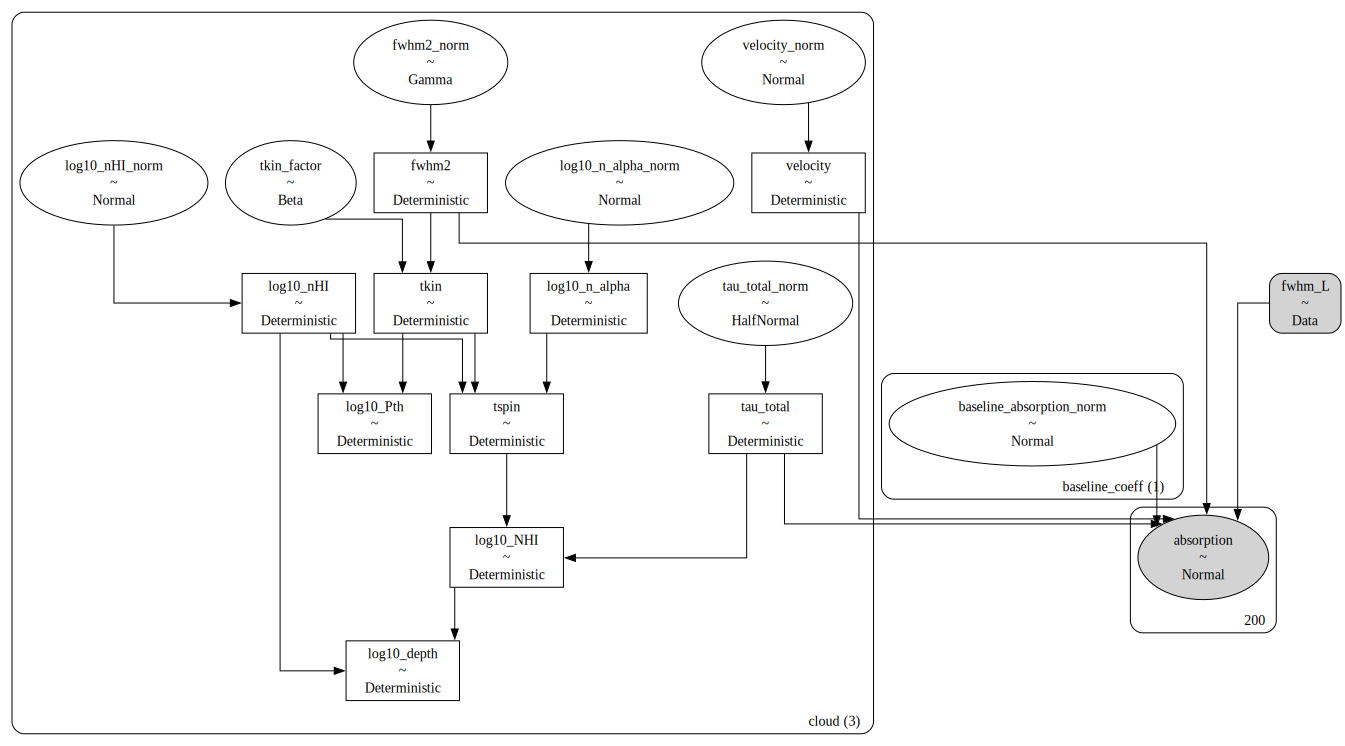

In [8]:
# Plot model graph
model.graph().render('absorption_model', format='png')
model.graph()

In [9]:
# model string representation
print(model.model.str_repr())

baseline_absorption_norm ~ Normal(0, 1)
              fwhm2_norm ~ Gamma(0.5, f())
          log10_nHI_norm ~ Normal(0, 1)
           velocity_norm ~ Normal(0, 1)
      log10_n_alpha_norm ~ Normal(0, 1)
          tau_total_norm ~ HalfNormal(0, 1)
             tkin_factor ~ Beta(2, 2)
                   fwhm2 ~ Deterministic(f(fwhm2_norm))
               log10_nHI ~ Deterministic(f(log10_nHI_norm))
                velocity ~ Deterministic(f(velocity_norm))
           log10_n_alpha ~ Deterministic(f(log10_n_alpha_norm))
               tau_total ~ Deterministic(f(tau_total_norm))
                    tkin ~ Deterministic(f(tkin_factor, fwhm2_norm))
                   tspin ~ Deterministic(f(tkin_factor, log10_n_alpha_norm, fwhm2_norm, log10_nHI_norm))
               log10_Pth ~ Deterministic(f(log10_nHI_norm, tkin_factor, fwhm2_norm))
               log10_NHI ~ Deterministic(f(tau_total_norm, tkin_factor, log10_n_alpha_norm, fwhm2_norm, log10_nHI_norm))
             log10_depth ~ Determini

We check that our prior distributions are reasonable by drawing prior predictive checks. Each colored line is a simulated "observation" with parameters drawn from the prior distributions. You should check that these simulated observations at least somewhat overlap your actual observation (black line).

Sampling: [absorption, baseline_absorption_norm, fwhm2_norm, log10_nHI_norm, log10_n_alpha_norm, tau_total_norm, tkin_factor, velocity_norm]


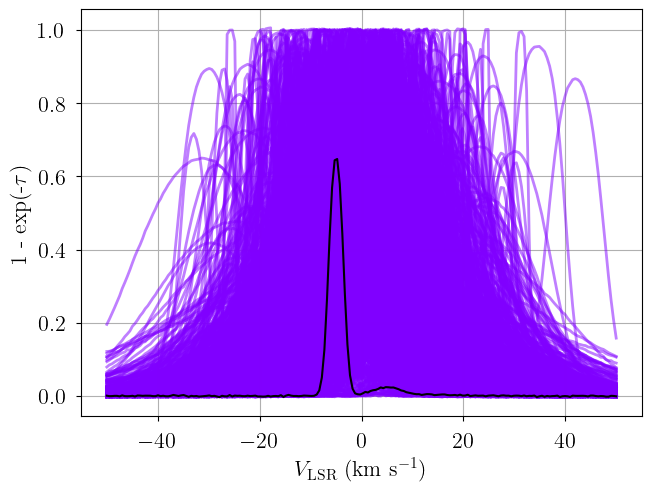

In [10]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=1000,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

We can also check out our prior distributions impact the deterministic (derived) quantities in our model. The red points represent the simulation parameters.

In [11]:
print(model.cloud_freeRVs)
print(model.cloud_deterministics)

['fwhm2_norm', 'log10_nHI_norm', 'velocity_norm', 'log10_n_alpha_norm', 'tau_total_norm', 'tkin_factor']
['fwhm2', 'log10_nHI', 'velocity', 'log10_n_alpha', 'tau_total', 'tkin', 'tspin', 'log10_Pth', 'log10_NHI', 'log10_depth']


['fwhm2', 'log10_nHI', 'velocity', 'log10_n_alpha', 'tau_total', 'tkin', 'tspin', 'log10_Pth', 'log10_NHI', 'log10_depth', 'tkin_factor']


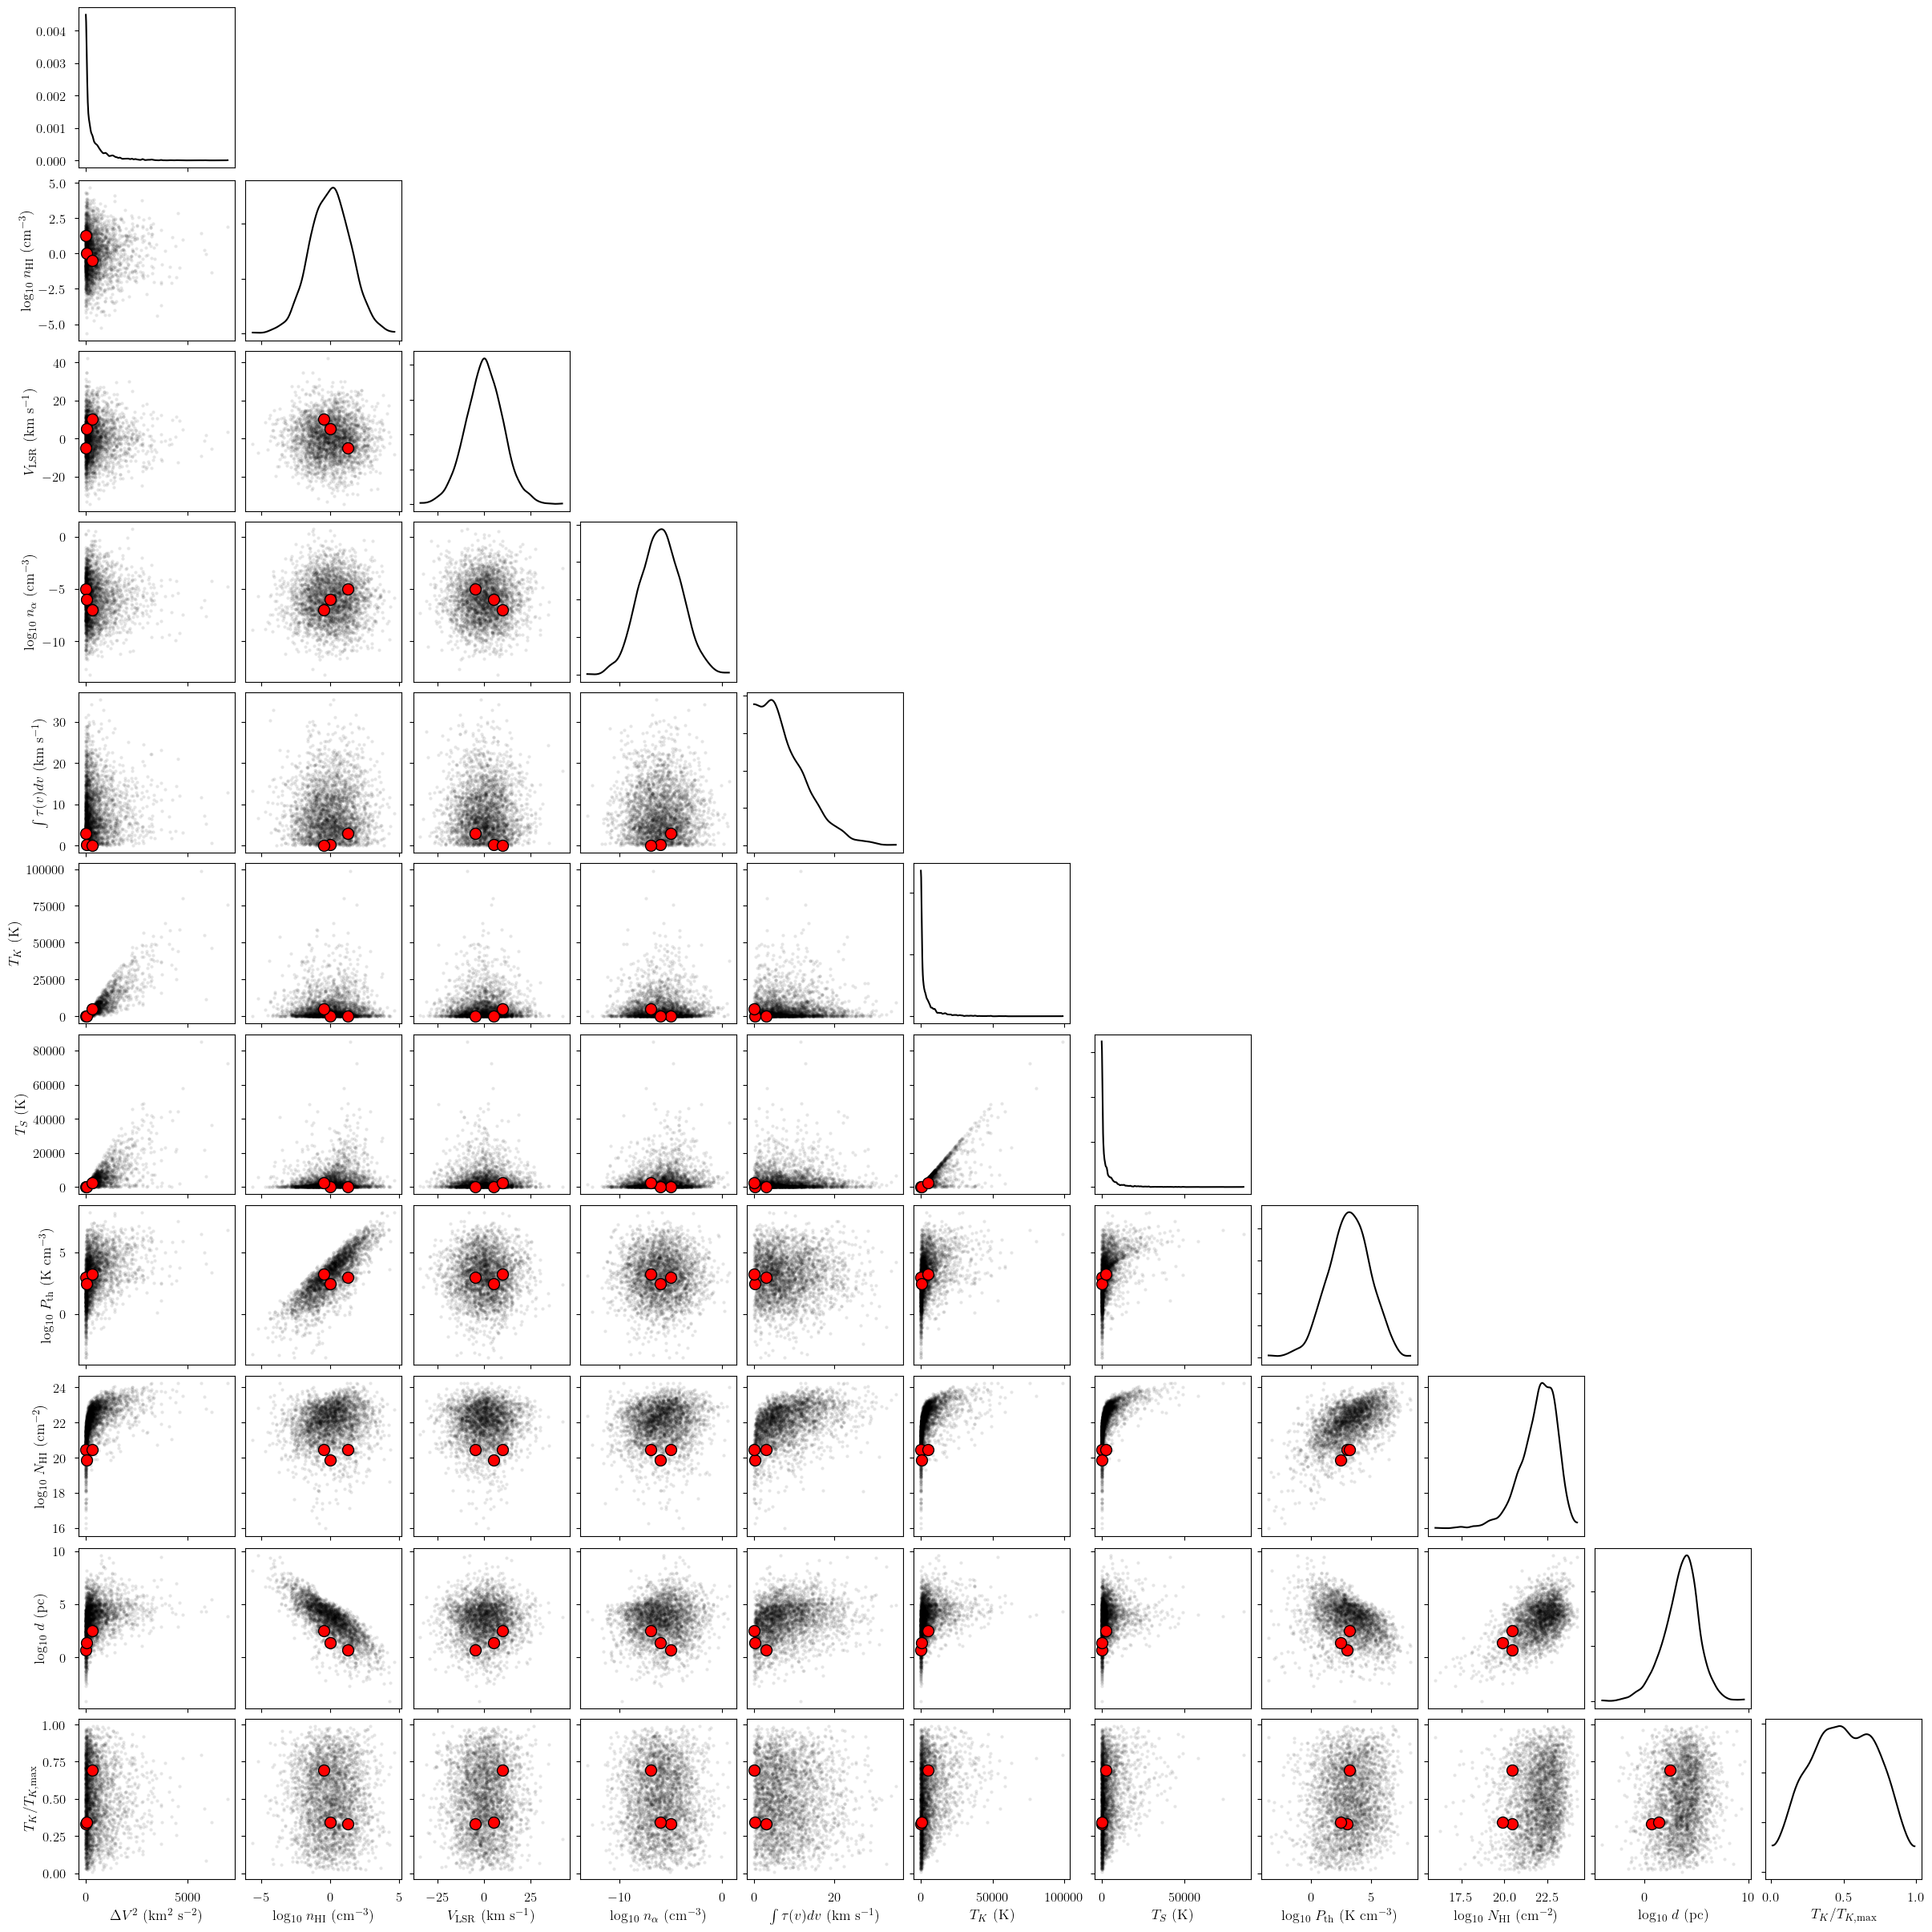

In [12]:
from bayes_spec.plots import plot_pair

var_names = model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
print(var_names)
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

We can approximate the posterior distribution using variational inference.

In [13]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.05, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
    start = {"velocity_norm": np.linspace(-1.0, 1.0, n_clouds)},
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 11200
Interrupted at 11,199 [11%]: Average Loss = 2.6966e+05


Output()

Runtime: 0.75 minutes


In [14]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean        sd   hdi_3%   hdi_97%  mcse_mean  \
baseline_absorption_norm[0]    -0.808     0.077   -0.982    -0.685      0.003   
log10_nHI_norm[0]              -0.054     1.071   -1.928     2.043      0.032   
log10_nHI_norm[1]              -0.029     1.184   -2.230     2.298      0.037   
log10_nHI_norm[2]               0.021     1.012   -2.038     1.785      0.036   
velocity_norm[0]                0.494     0.007    0.482     0.506      0.000   
velocity_norm[1]               -0.500     0.000   -0.501    -0.500      0.000   
velocity_norm[2]                0.874     0.067    0.743     0.997      0.002   
log10_n_alpha_norm[0]          -0.007     1.094   -1.957     2.129      0.035   
log10_n_alpha_norm[1]           0.059     1.123   -2.135     2.103      0.034   
log10_n_alpha_norm[2]          -0.051     1.116   -2.168     2.048      0.037   
fwhm2_norm[0]                   0.075     0.003    0.069     0.080      0.000   
fwhm2_norm[1]                   0.014     0.000    0.014     0.014      0.000   
fwhm2_norm[2]                   0.966     0.101    0.768     1.151      0.003   
tau_total_norm[0]               0.014     0.000    0.013     0.014      0.000   
tau_total_norm[1]               0.301     0.000    0.300     0.302      0.000   
tau_total_norm[2]               0.010     0.000    0.009     0.010      0.000   
tkin_factor[0]                  0.504     0.239    0.080     0.892      0.008   
tkin_factor[1]                  0.503     0.225    0.124     0.912      0.007   
tkin_factor[2]                  0.494     0.232    0.104     0.900      0.007   
fwhm2[0]                       37.469     1.493   34.676    40.241      0.044   
fwhm2[1]                        6.852     0.015    6.824     6.882      0.000   
fwhm2[2]                      483.118    50.600  383.938   575.735      1.627   
log10_nHI[0]                   -0.081     1.606   -2.892     3.065      0.048   
log10_nHI[1]                   -0.043     1.776   -3.345     3.447      0.055   
log10_nHI[2]                    0.031     1.519   -3.056     2.678      0.054   
velocity[0]                     4.944     0.066    4.819     5.060      0.002   
velocity[1]                    -5.004     0.002   -5.007    -5.000      0.000   
velocity[2]                     8.742     0.671    7.432     9.972      0.022   
log10_n_alpha[0]               -6.013     2.189   -9.914    -1.742      0.069   
log10_n_alpha[1]               -5.881     2.247  -10.269    -1.793      0.068   
log10_n_alpha[2]               -6.101     2.232  -10.337    -1.904      0.075   
tau_total[0]                    0.138     0.002    0.133     0.142      0.000   
tau_total[1]                    3.010     0.004    3.003     3.016      0.000   
tau_total[2]                    0.095     0.004    0.088     0.104      0.000   
tkin[0]                       412.753   196.878   50.619   722.502      6.406   
tkin[1]                        75.388    33.743   18.697   136.752      1.049   
tkin[2]                      5214.140  2504.657  831.241  9339.489     79.053   
tspin[0]                      379.314   197.399   52.274   716.461      6.677   
tspin[1]                       73.302    33.776   16.322   134.356      0.983   
tspin[2]                     4100.034  2541.316   30.277  8438.733     76.690   
log10_Pth[0]                    2.464     1.633   -0.569     5.379      0.049   
log10_Pth[1]                    1.773     1.810   -1.863     5.018      0.056   
log10_Pth[2]                    3.681     1.535    0.787     6.510      0.054   
log10_NHI[0]                   19.890     0.327   19.252    20.296      0.011   
log10_NHI[1]                   20.539     0.270   20.017    20.886      0.008   
log10_NHI[2]                   20.721     0.414   19.980    21.264      0.012   
log10_depth[0]                  1.482     1.563   -1.602     4.289      0.046   
log10_depth[1]                  2.093     1.761   -1.182     5.412      0.055   
log10_depth[2]                  2.200     1.414   -0.525     5.1

Sampling: [absorption]


Output()

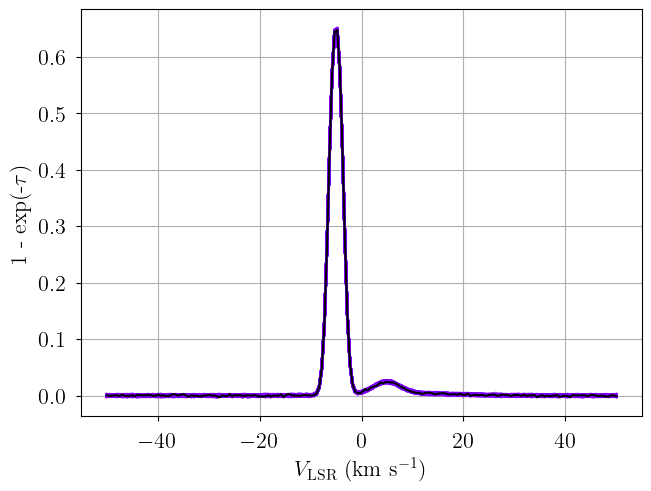

In [15]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

We can sample from the posterior distribution using MCMC.

In [16]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=8,  # number of independent chains
    cores=8,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.05,
        "abs_tolerance": 0.05,
        "learning_rate": 0.01,
        "start": {"velocity_norm": np.linspace(-1.0, 1.0, n_clouds)},
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.8},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 11200
Interrupted at 11,199 [11%]: Average Loss = 2.6966e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_absorption_norm, fwhm2_norm, log10_nHI_norm, velocity_norm, log10_n_alpha_norm, tau_total_norm, tkin_factor]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Adding log-likelihood to trace


Output()

There were 89 divergences in converged chains.
Runtime: 0.72 minutes


The FWHM line width and velocity are a little correlated in this model, so it's poorly approximated by a Gaussian Mixture Model (GMM). We increase the KL-divergence threshold here to compensate, but then we scrutinize the results closely.

In [17]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


Check that the effective sample sizes are large and the covergence statistic `r_hat` is close to 1! If not, you may have to increase the number of tuning steps (`tune=2000`) or the NUTS acceptance rate (`target_accept=0.9`).

In [18]:
print("solutions:", model.solutions)
az.summary(model.trace["solution_0"])
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean        sd   hdi_3%   hdi_97%  mcse_mean  \
baseline_absorption_norm[0]    -0.807     0.099   -0.998    -0.621      0.001   
log10_nHI_norm[0]              -0.010     1.004   -1.922     1.832      0.011   
log10_nHI_norm[1]              -0.012     1.007   -1.932     1.841      0.011   
log10_nHI_norm[2]               0.023     1.019   -1.832     1.972      0.011   
velocity_norm[0]                0.494     0.007    0.481     0.509      0.000   
velocity_norm[1]               -0.500     0.000   -0.500    -0.500      0.000   
velocity_norm[2]                0.923     0.150    0.655     1.192      0.004   
log10_n_alpha_norm[0]          -0.005     0.971   -1.881     1.773      0.010   
log10_n_alpha_norm[1]           0.002     1.001   -1.873     1.897      0.010   
log10_n_alpha_norm[2]           0.003     1.011   -1.906     1.889      0.011   
fwhm2_norm[0]                   0.077     0.006    0.066     0.089      0.000   
fwhm2_norm[1]                   0.014     0.000    0.014     0.014      0.000   
fwhm2_norm[2]                   0.926     0.194    0.570     1.308      0.004   
tau_total_norm[0]               0.014     0.001    0.012     0.016      0.000   
tau_total_norm[1]               0.301     0.000    0.300     0.302      0.000   
tau_total_norm[2]               0.009     0.001    0.006     0.012      0.000   
tkin_factor[0]                  0.500     0.224    0.116     0.909      0.002   
tkin_factor[1]                  0.499     0.224    0.103     0.894      0.002   
tkin_factor[2]                  0.505     0.224    0.099     0.893      0.002   
fwhm2[0]                       38.451     3.000   33.189    44.399      0.071   
fwhm2[1]                        6.843     0.017    6.810     6.875      0.000   
fwhm2[2]                      462.755    97.229  284.787   654.247      2.127   
log10_nHI[0]                   -0.015     1.506   -2.883     2.748      0.016   
log10_nHI[1]                   -0.018     1.510   -2.898     2.761      0.016   
log10_nHI[2]                    0.035     1.529   -2.747     2.958      0.016   
velocity[0]                     4.945     0.073    4.814     5.087      0.001   
velocity[1]                    -5.001     0.001   -5.003    -4.998      0.000   
velocity[2]                     9.231     1.499    6.548    11.919      0.041   
log10_n_alpha[0]               -6.010     1.942   -9.762    -2.454      0.019   
log10_n_alpha[1]               -5.996     2.003   -9.746    -2.207      0.021   
log10_n_alpha[2]               -5.994     2.022   -9.812    -2.222      0.021   
tau_total[0]                    0.139     0.009    0.122     0.156      0.000   
tau_total[1]                    3.007     0.004    3.000     3.015      0.000   
tau_total[2]                    0.092     0.015    0.063     0.118      0.000   
tkin[0]                       420.002   191.471   74.577   756.932      2.141   
tkin[1]                        74.565    33.505   14.872   133.053      0.330   
tkin[2]                      5113.685  2573.435  518.075  9556.899     36.782   
tspin[0]                      394.522   189.337   45.936   716.457      2.207   
tspin[1]                       72.830    33.253   14.882   132.187      0.334   
tspin[2]                     4010.462  2560.091    3.973  8397.221     40.186   
log10_Pth[0]                    2.546     1.530   -0.398     5.349      0.016   
log10_Pth[1]                    1.794     1.530   -1.080     4.624      0.017   
log10_Pth[2]                    3.672     1.562    0.776     6.612      0.017   
log10_NHI[0]                   19.928     0.286   19.380    20.342      0.004   
log10_NHI[1]                   20.539     0.263   20.072    20.903      0.003   
log10_NHI[2]                   20.685     0.445   19.861    21.337      0.008   
log10_depth[0]                  1.454     1.491   -1.367     4.273      0.016   
log10_depth[1]                  2.067     1.522   -0.866     4.874      0.016   
log10_depth[2]                  2.161     1.403   -0.681     4.6

We generate posterior predictive checks as well as a trace plot of the individual chains. In the posterior predictive plot, we show each chain as a different color. Each line is one posterior sample.

Sampling: [absorption]


Output()

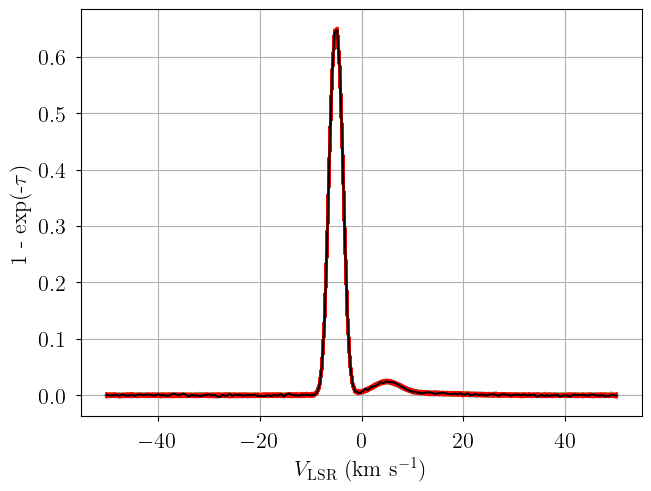

In [19]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

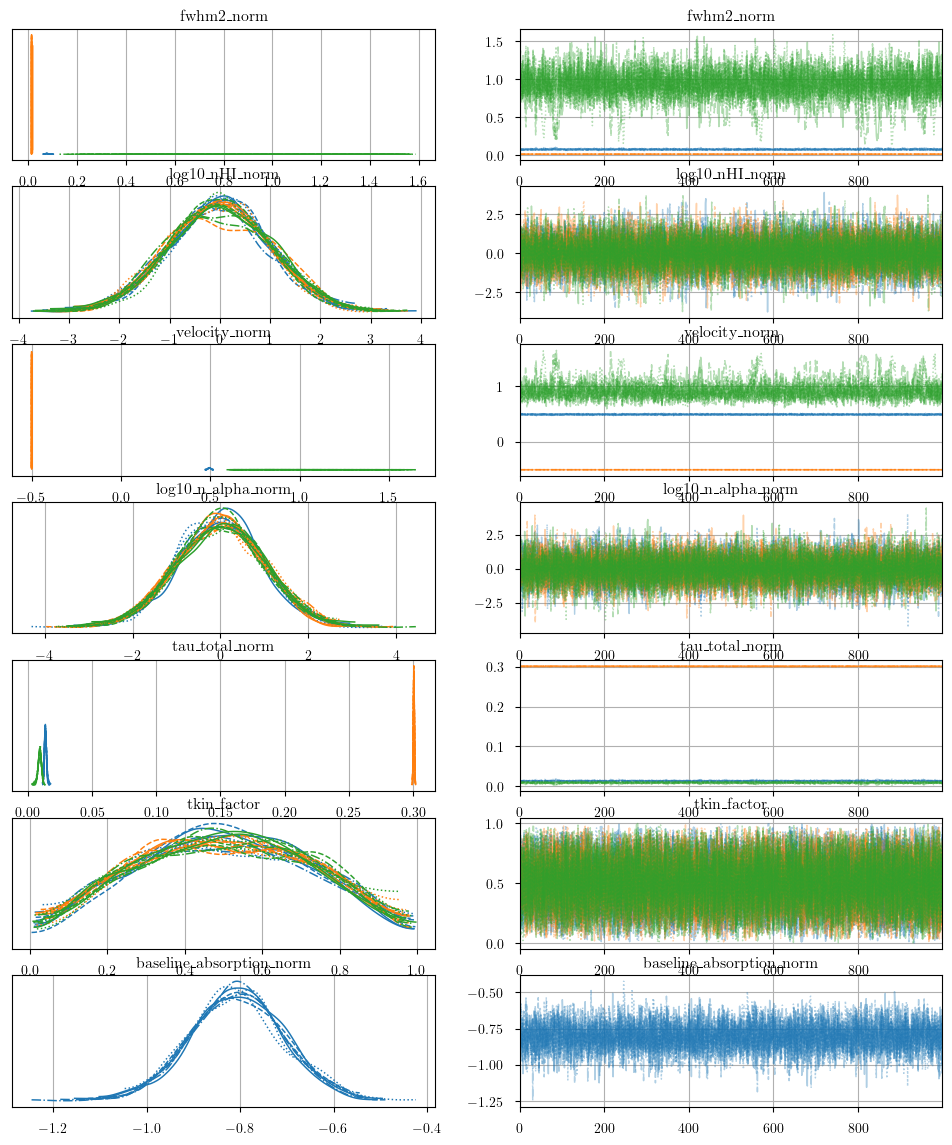

In [20]:
from bayes_spec.plots import plot_traces

_ = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)

We can inspect the posterior distribution pair plots. First, the free parameters for all clouds. Keep an eye out for any strong degeneracies or non-linear correlations. If present, then these features can cause the posterior sampling to be inefficient. It may be worth re-parameterizing your model to remove these effects. Alternatively, increasing `tune` and `target_accept` can help.

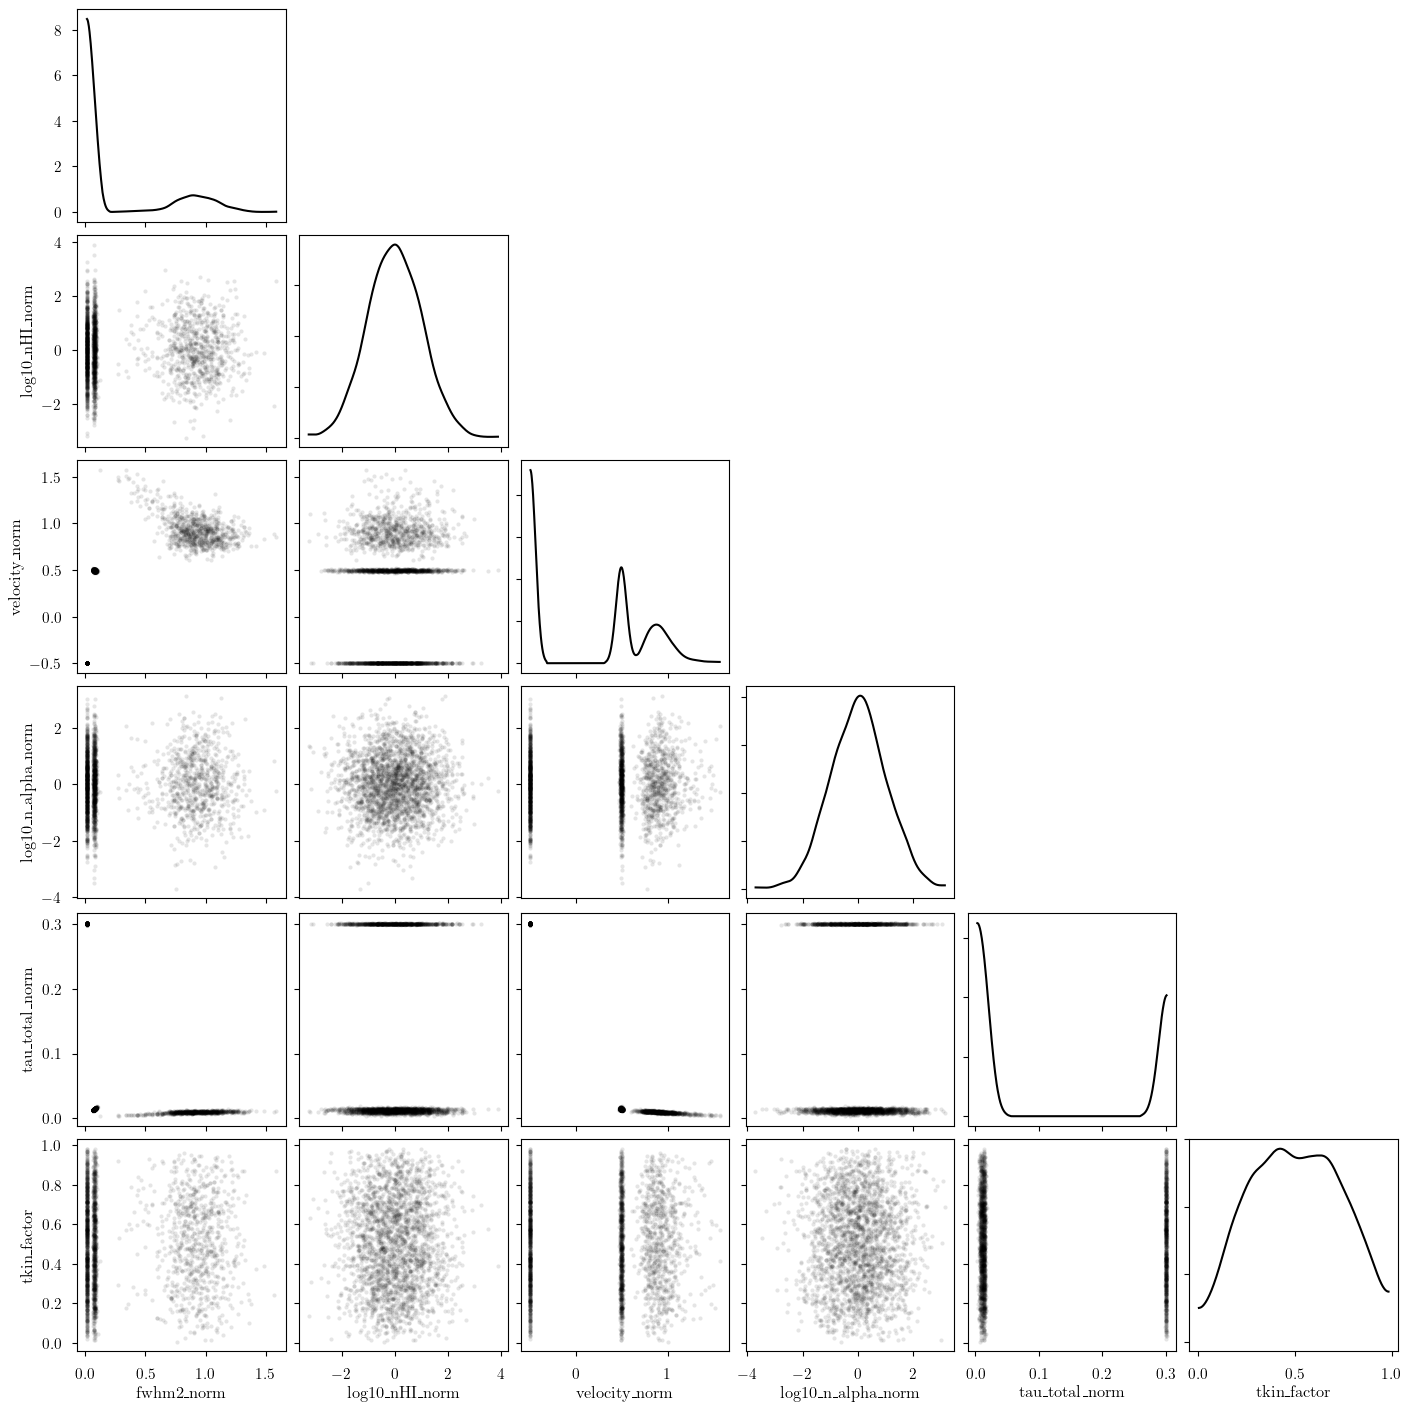

In [21]:
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    model.cloud_freeRVs, # var_names to plot
    kind="scatter", # plot type
)

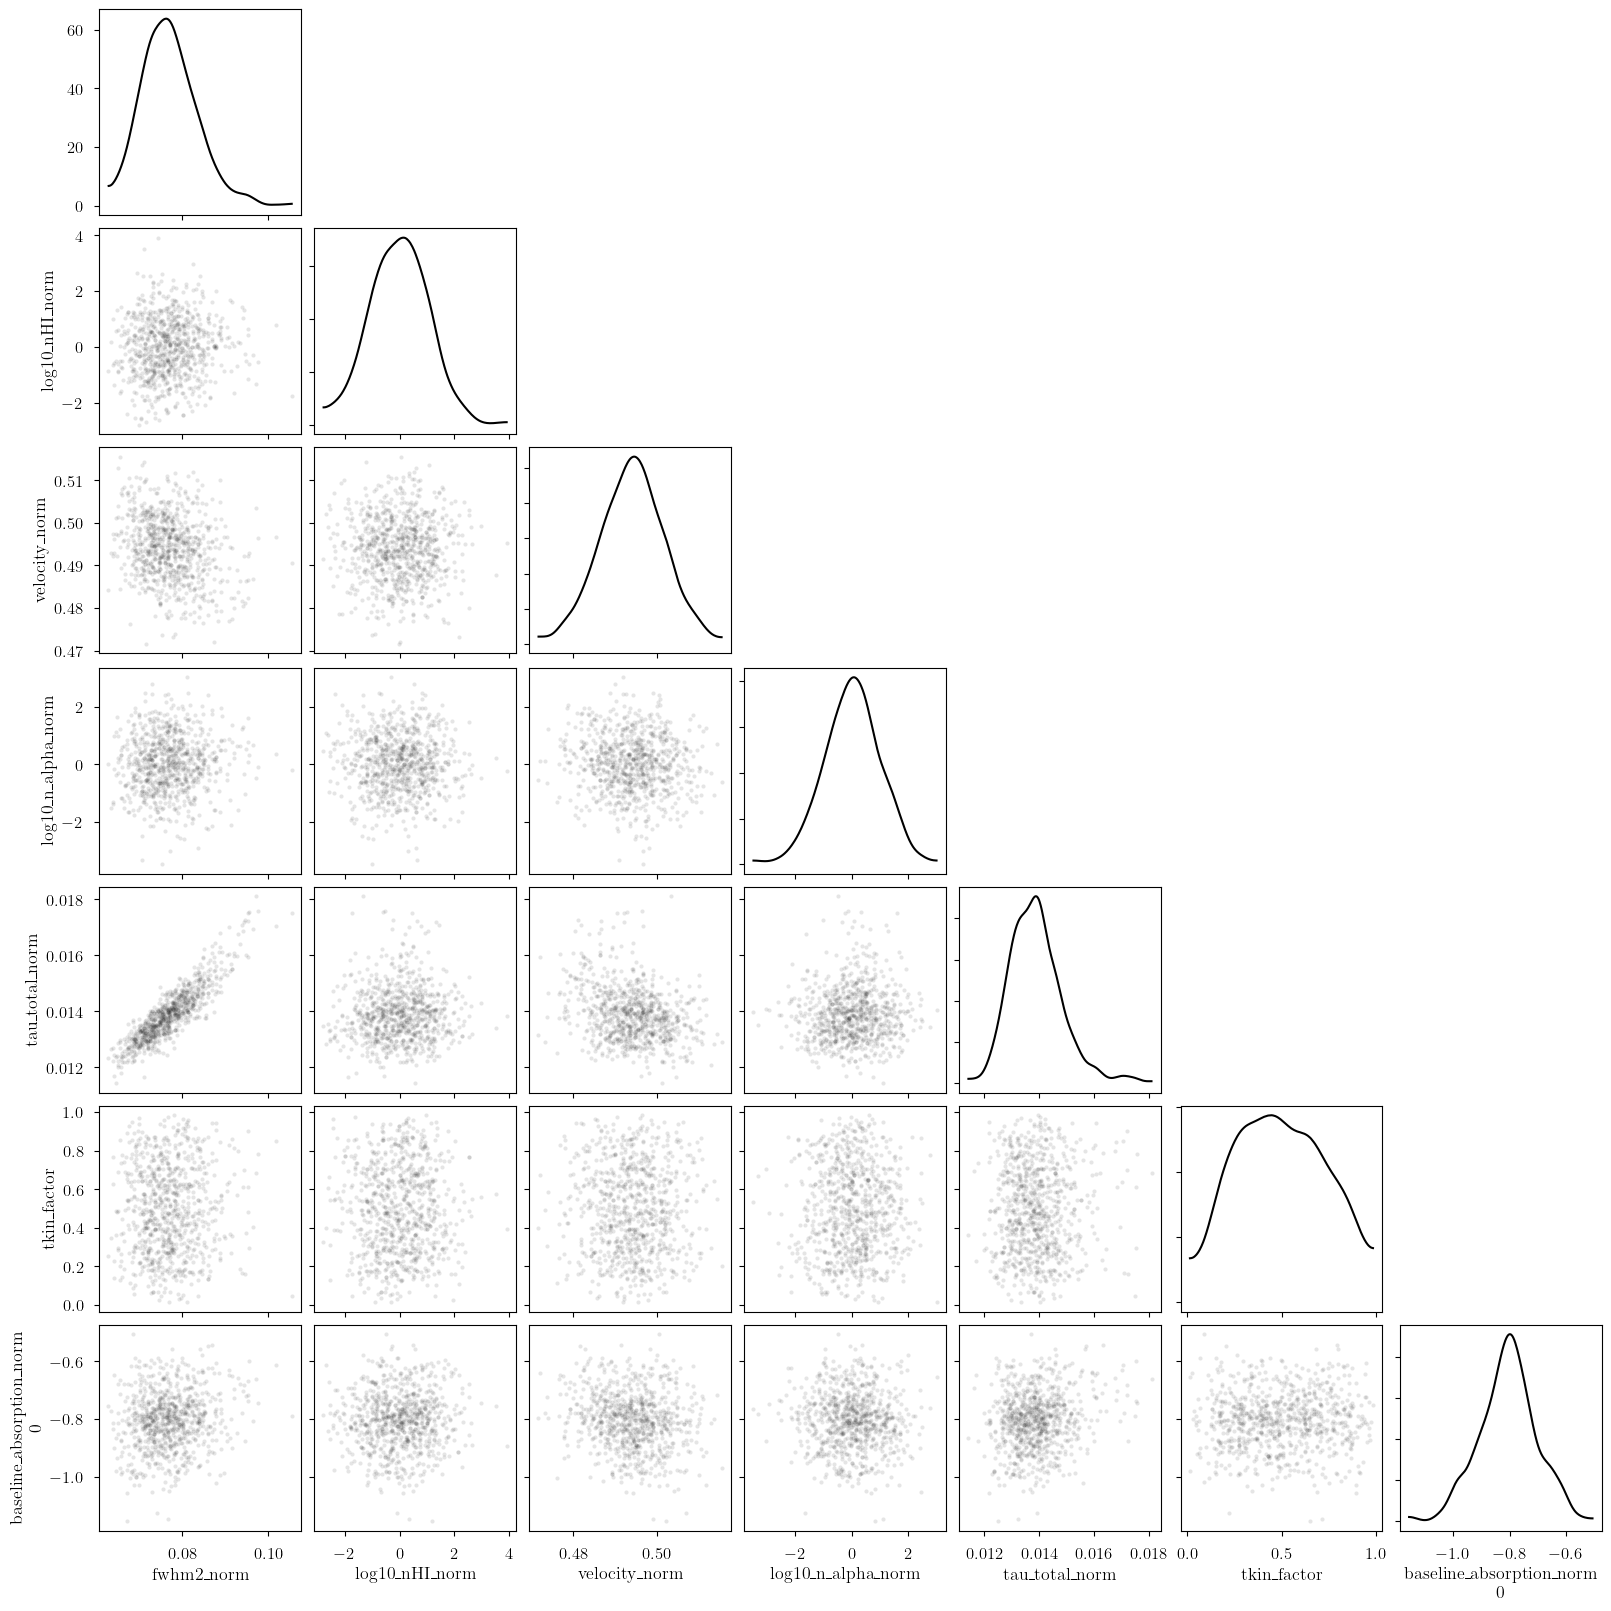

In [22]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0, draw=slice(None, None, 10)), # samples
    model.cloud_freeRVs + model.hyper_freeRVs + model.baseline_freeRVs, # var_names to plot
    kind="scatter", # plot type
)

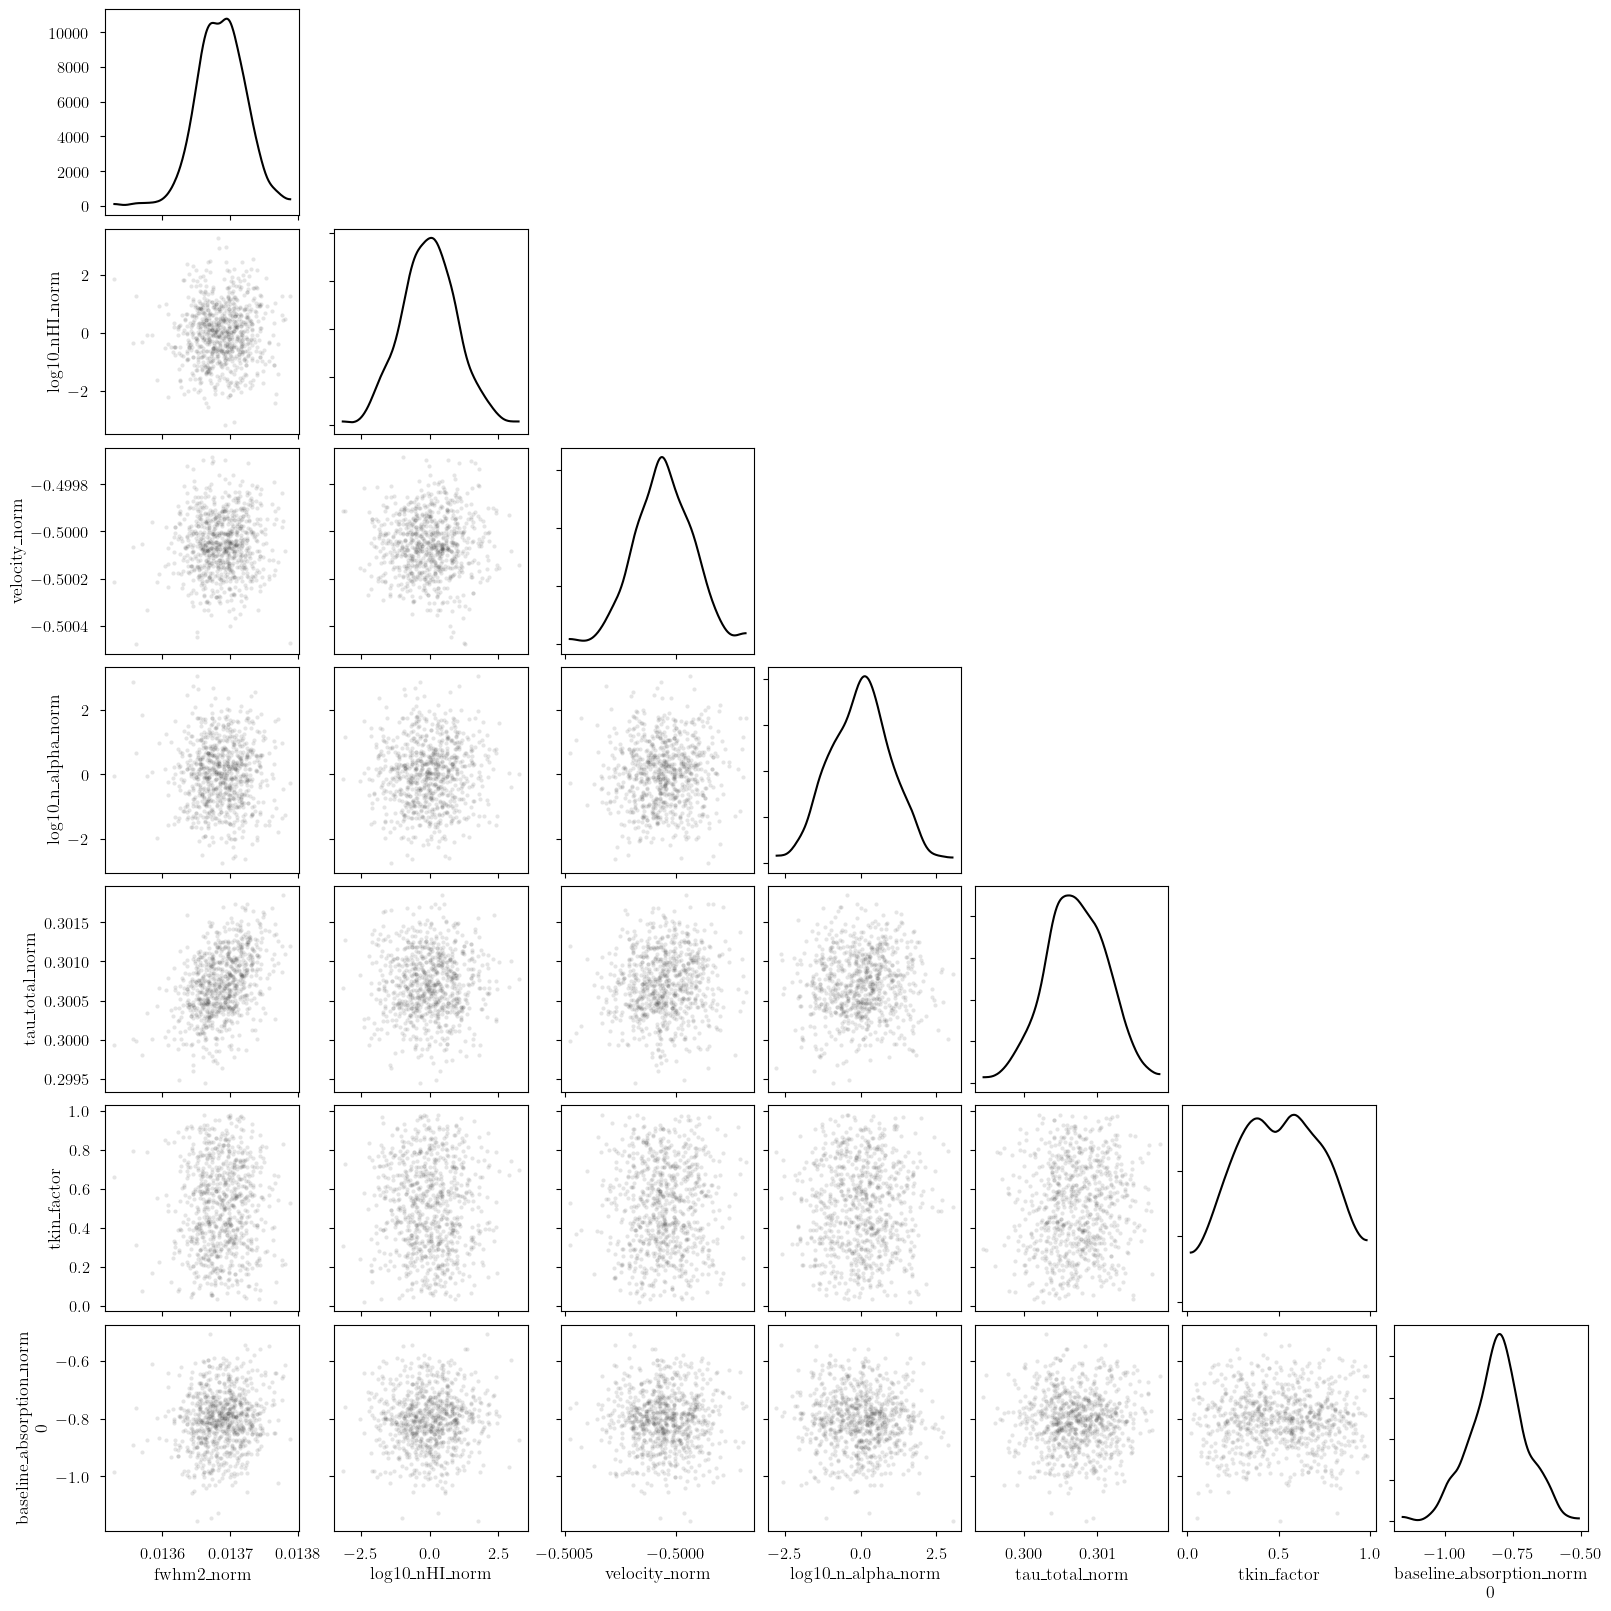

In [23]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1, draw=slice(None, None, 10)), # samples
    model.cloud_freeRVs + model.hyper_freeRVs + model.baseline_freeRVs, # var_names to plot
    kind="scatter", # plot type
)

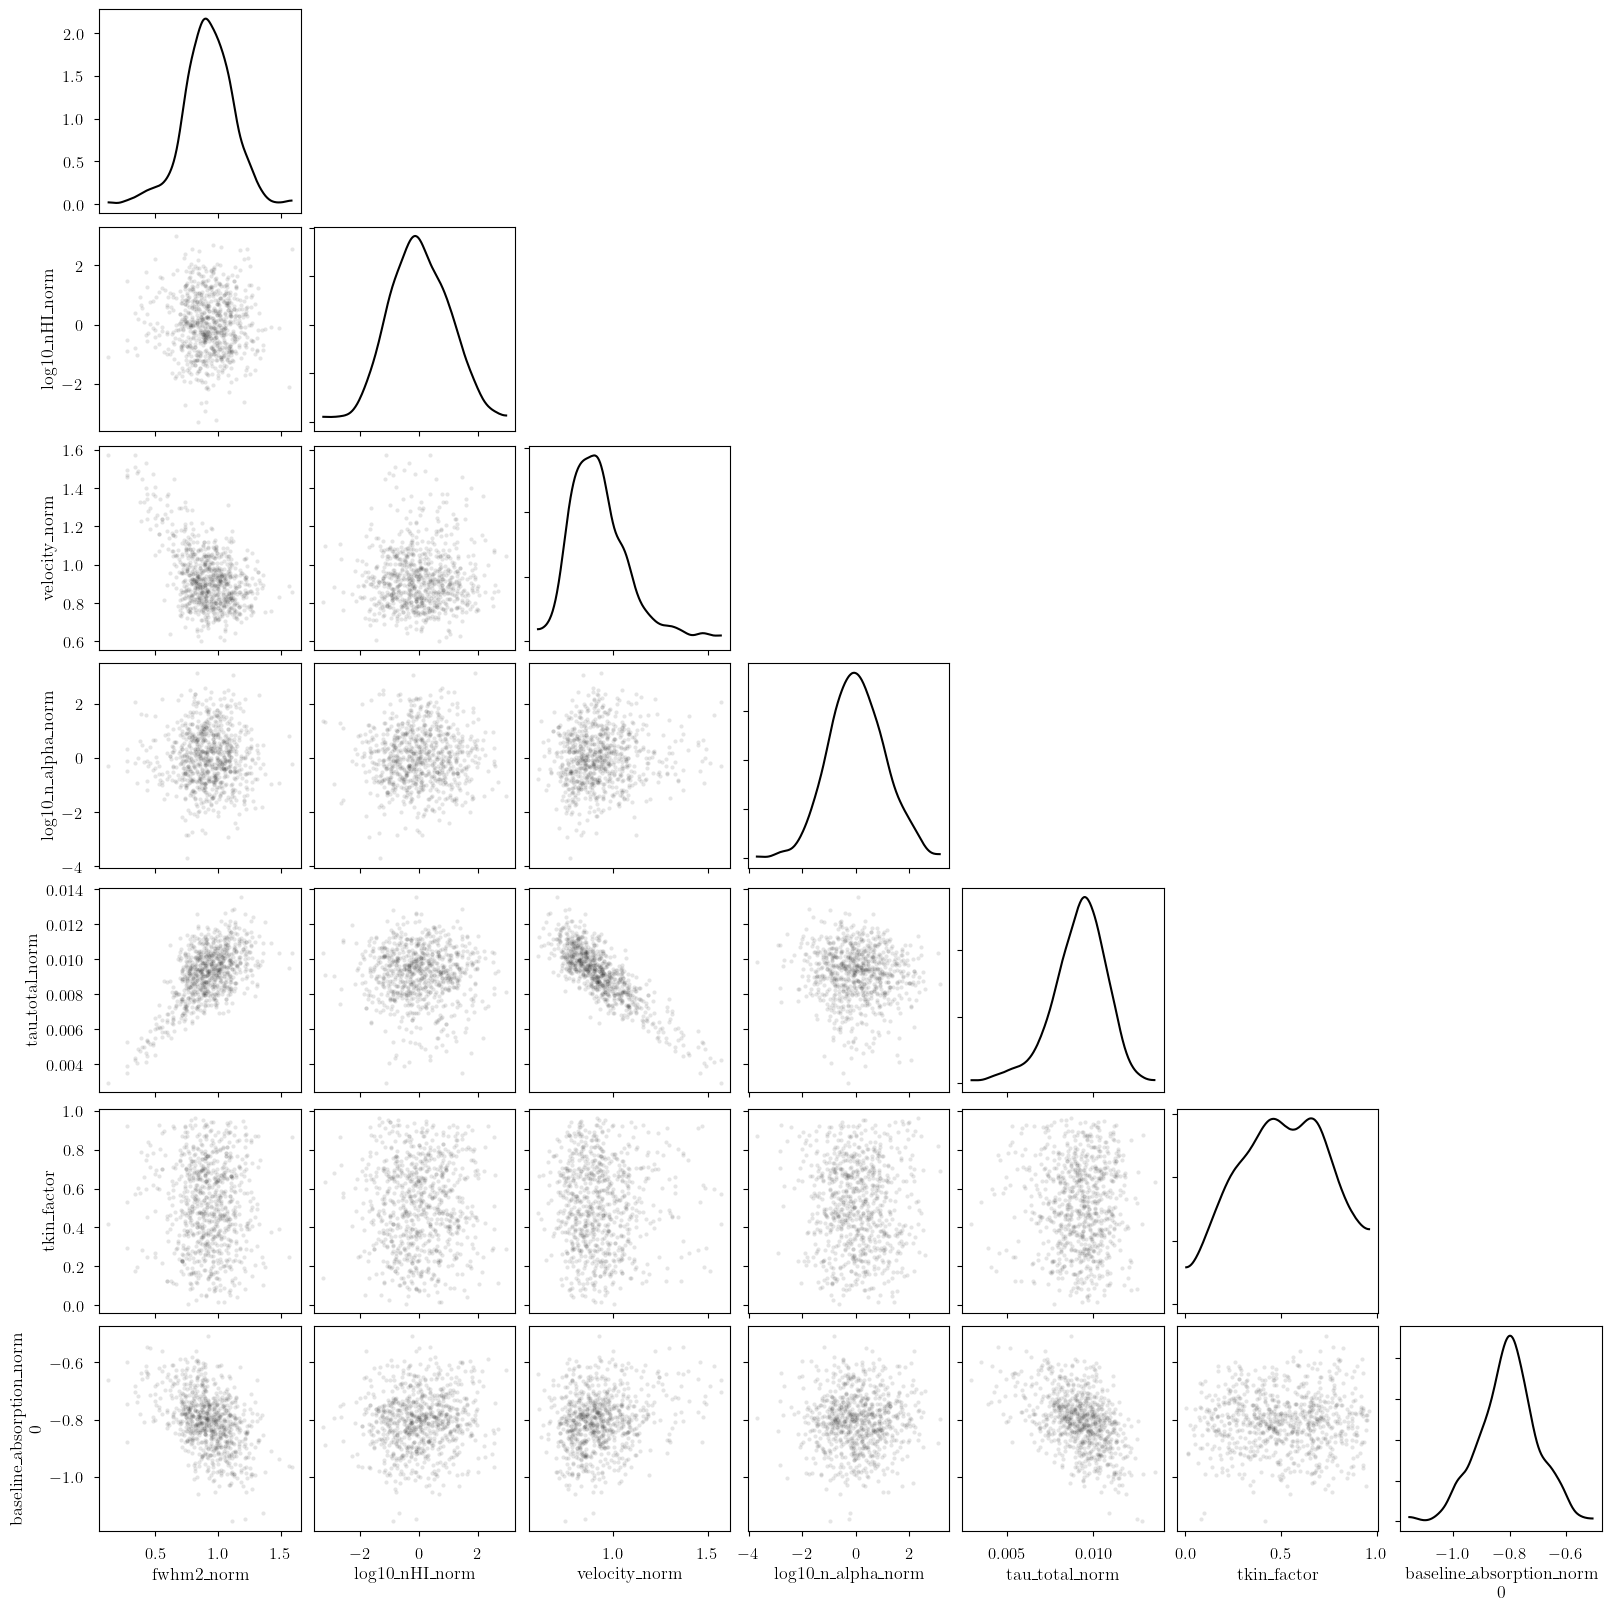

In [24]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2, draw=slice(None, None, 10)), # samples
    model.cloud_freeRVs + model.hyper_freeRVs + model.baseline_freeRVs, # var_names to plot
    kind="scatter", # plot type
)

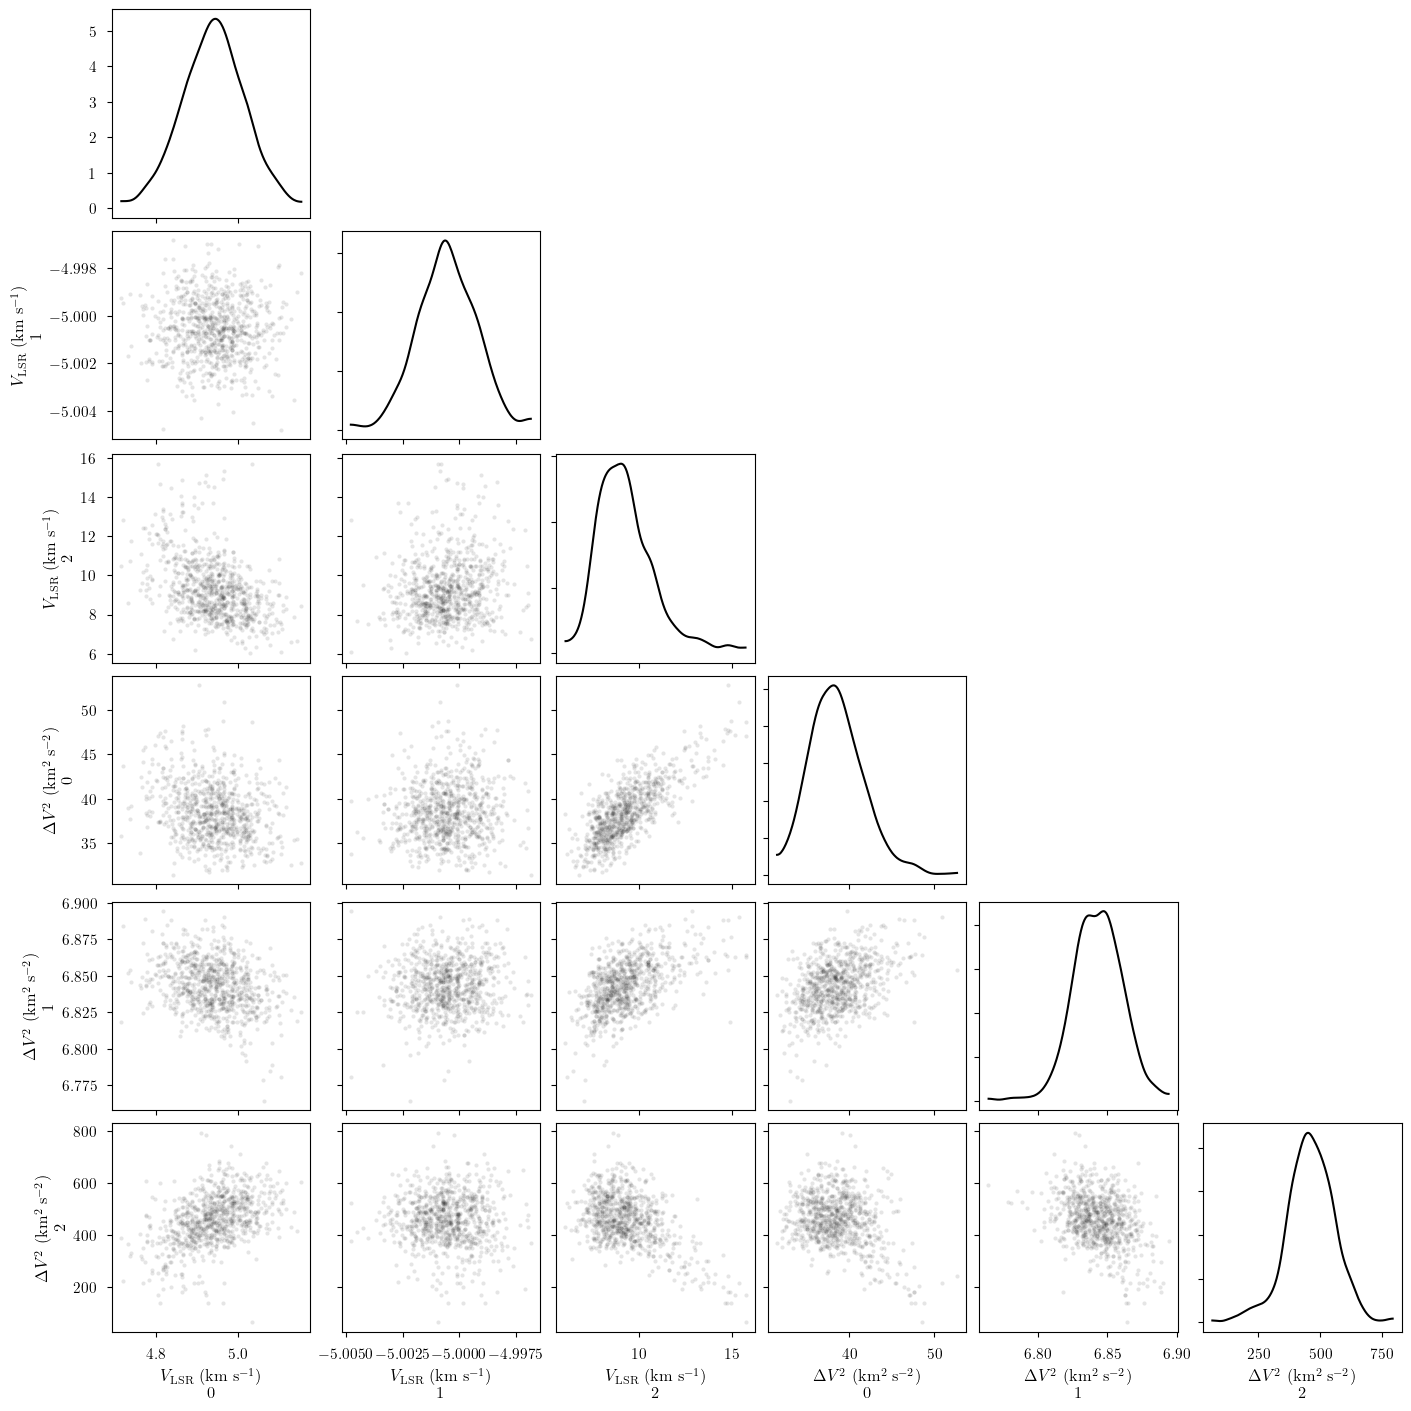

In [25]:
scatter_kwargs = {
    "marker": ".",
    "color": "k",
    "alpha": 0.1,
}
size = int(2.0 * (2 * model.n_clouds + 1))
textsize = int(np.sqrt(size)) + 8

with az.rc_context(rc={"plot.max_subplots": None}):
    axes = az.plot_pair(
        model.trace.solution_0.sel(draw=slice(None, None, 10)),
        var_names = ['velocity', 'fwhm2'],
        kind = 'scatter',
        figsize = (size, size),
        labeller = model.labeller,
        marginals = True,
        marginal_kwargs = {"color": "k"},
        textsize = textsize,
        scatter_kwargs = scatter_kwargs,
        backend_kwargs = {"layout": "constrained"},
    )
axes[0][0].set_ylabel("")
for ax in axes.flatten():
    ax.grid(False)

The red points represent the simulation parameters for the deterministic quantities.

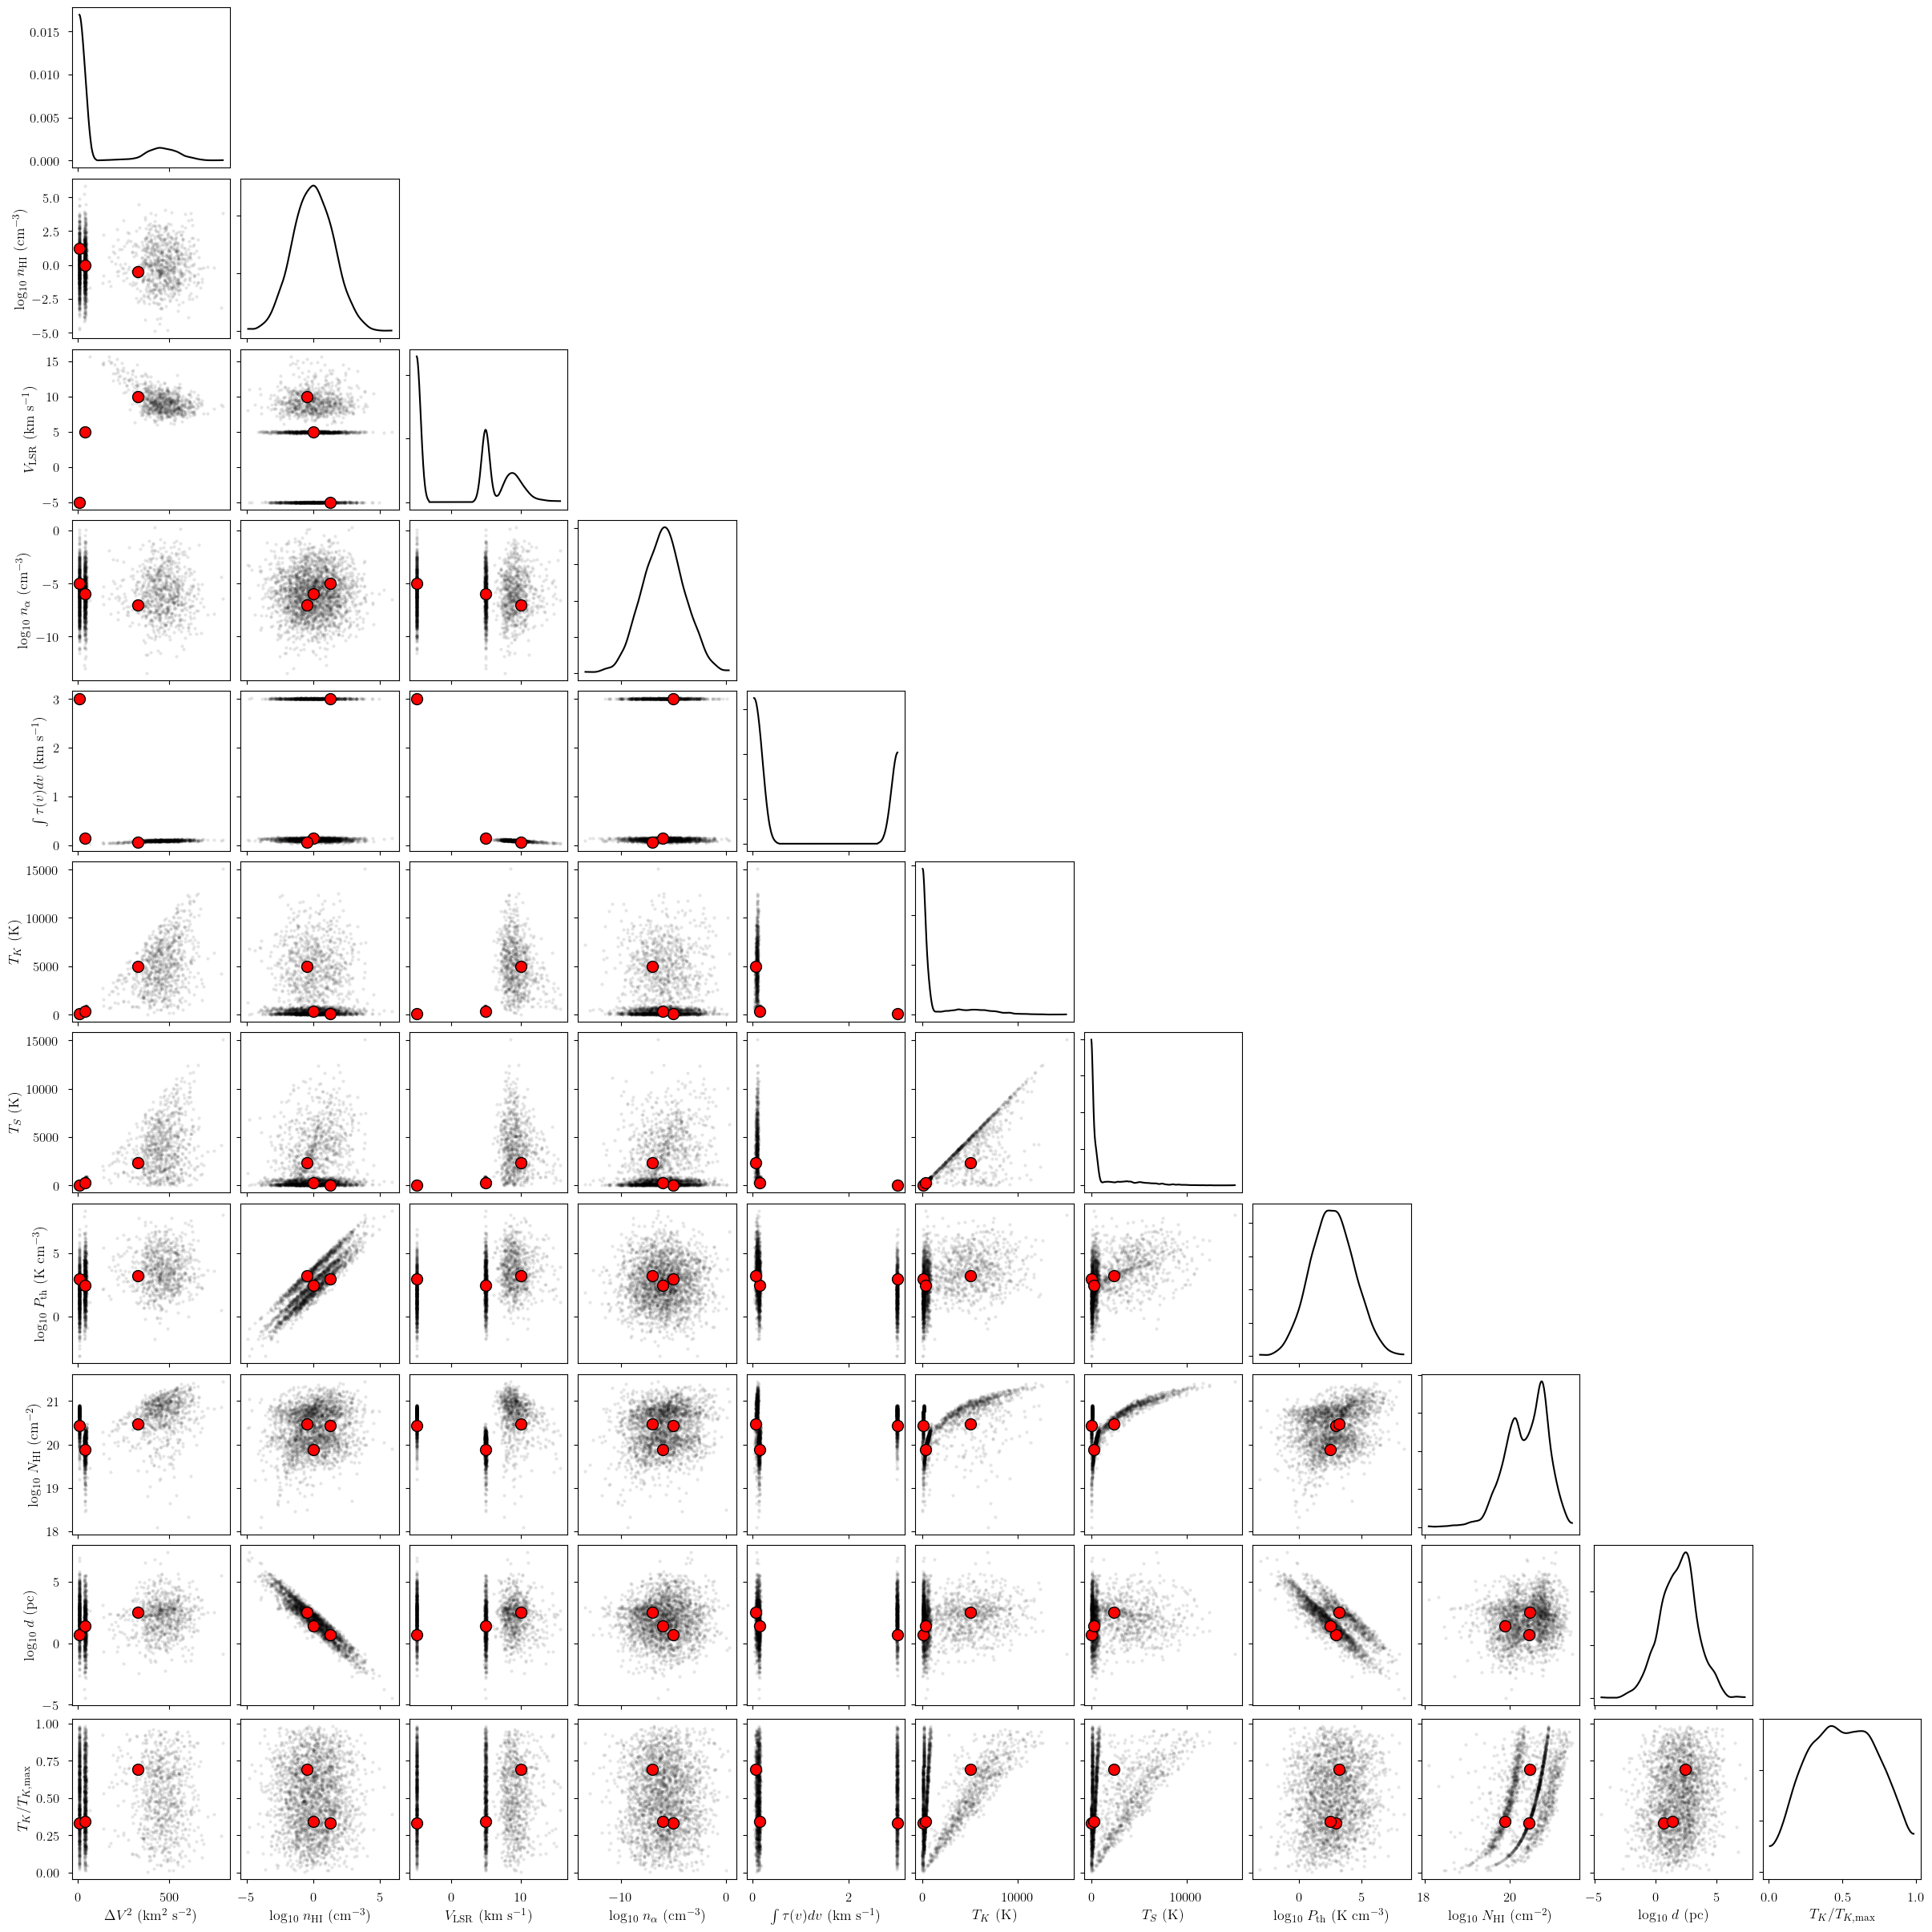

In [26]:
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

In [27]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(1), 1: np.int64(0), 2: np.int64(2)}

In [28]:
print("cloud freeRVs", model.cloud_freeRVs)
print("cloud deterministics", model.cloud_deterministics)
print("hyper freeRVs", model.hyper_freeRVs)
print("hyper deterministics", model.hyper_deterministics)

cloud freeRVs ['fwhm2_norm', 'log10_nHI_norm', 'velocity_norm', 'log10_n_alpha_norm', 'tau_total_norm', 'tkin_factor']
cloud deterministics ['fwhm2', 'log10_nHI', 'velocity', 'log10_n_alpha', 'tau_total', 'tkin', 'tspin', 'log10_Pth', 'log10_NHI', 'log10_depth']
hyper freeRVs []
hyper deterministics []


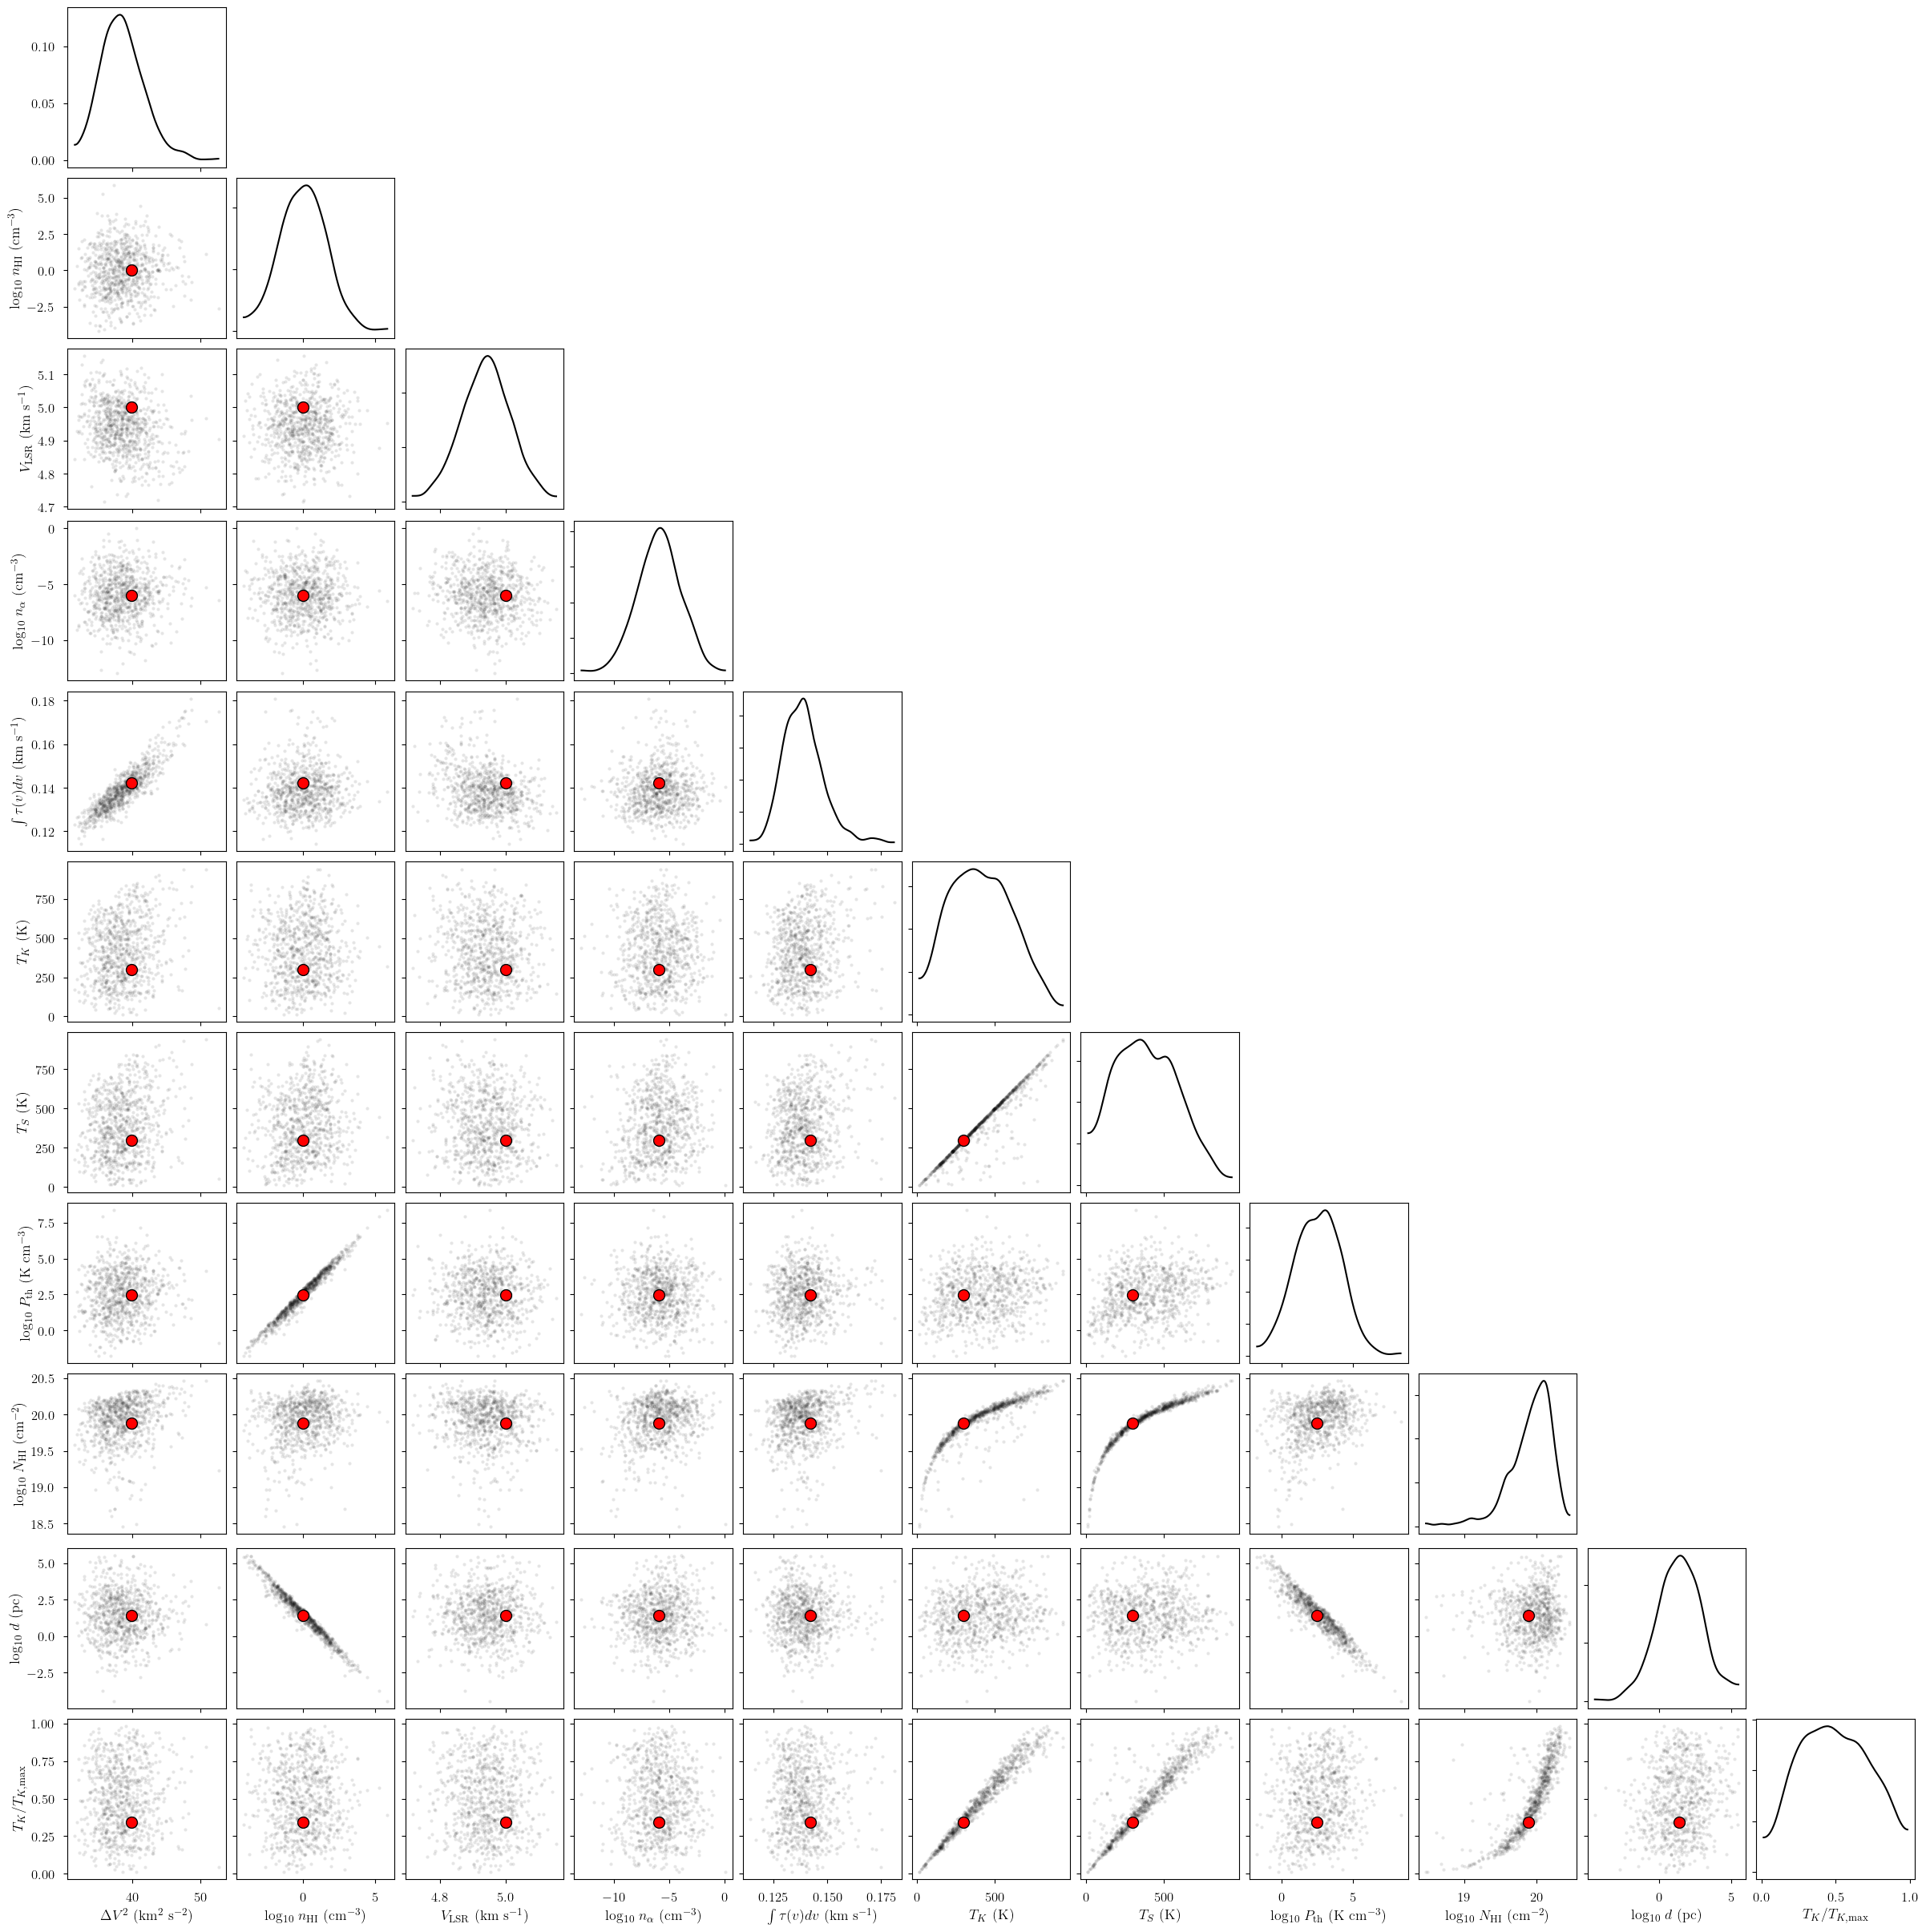

In [29]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

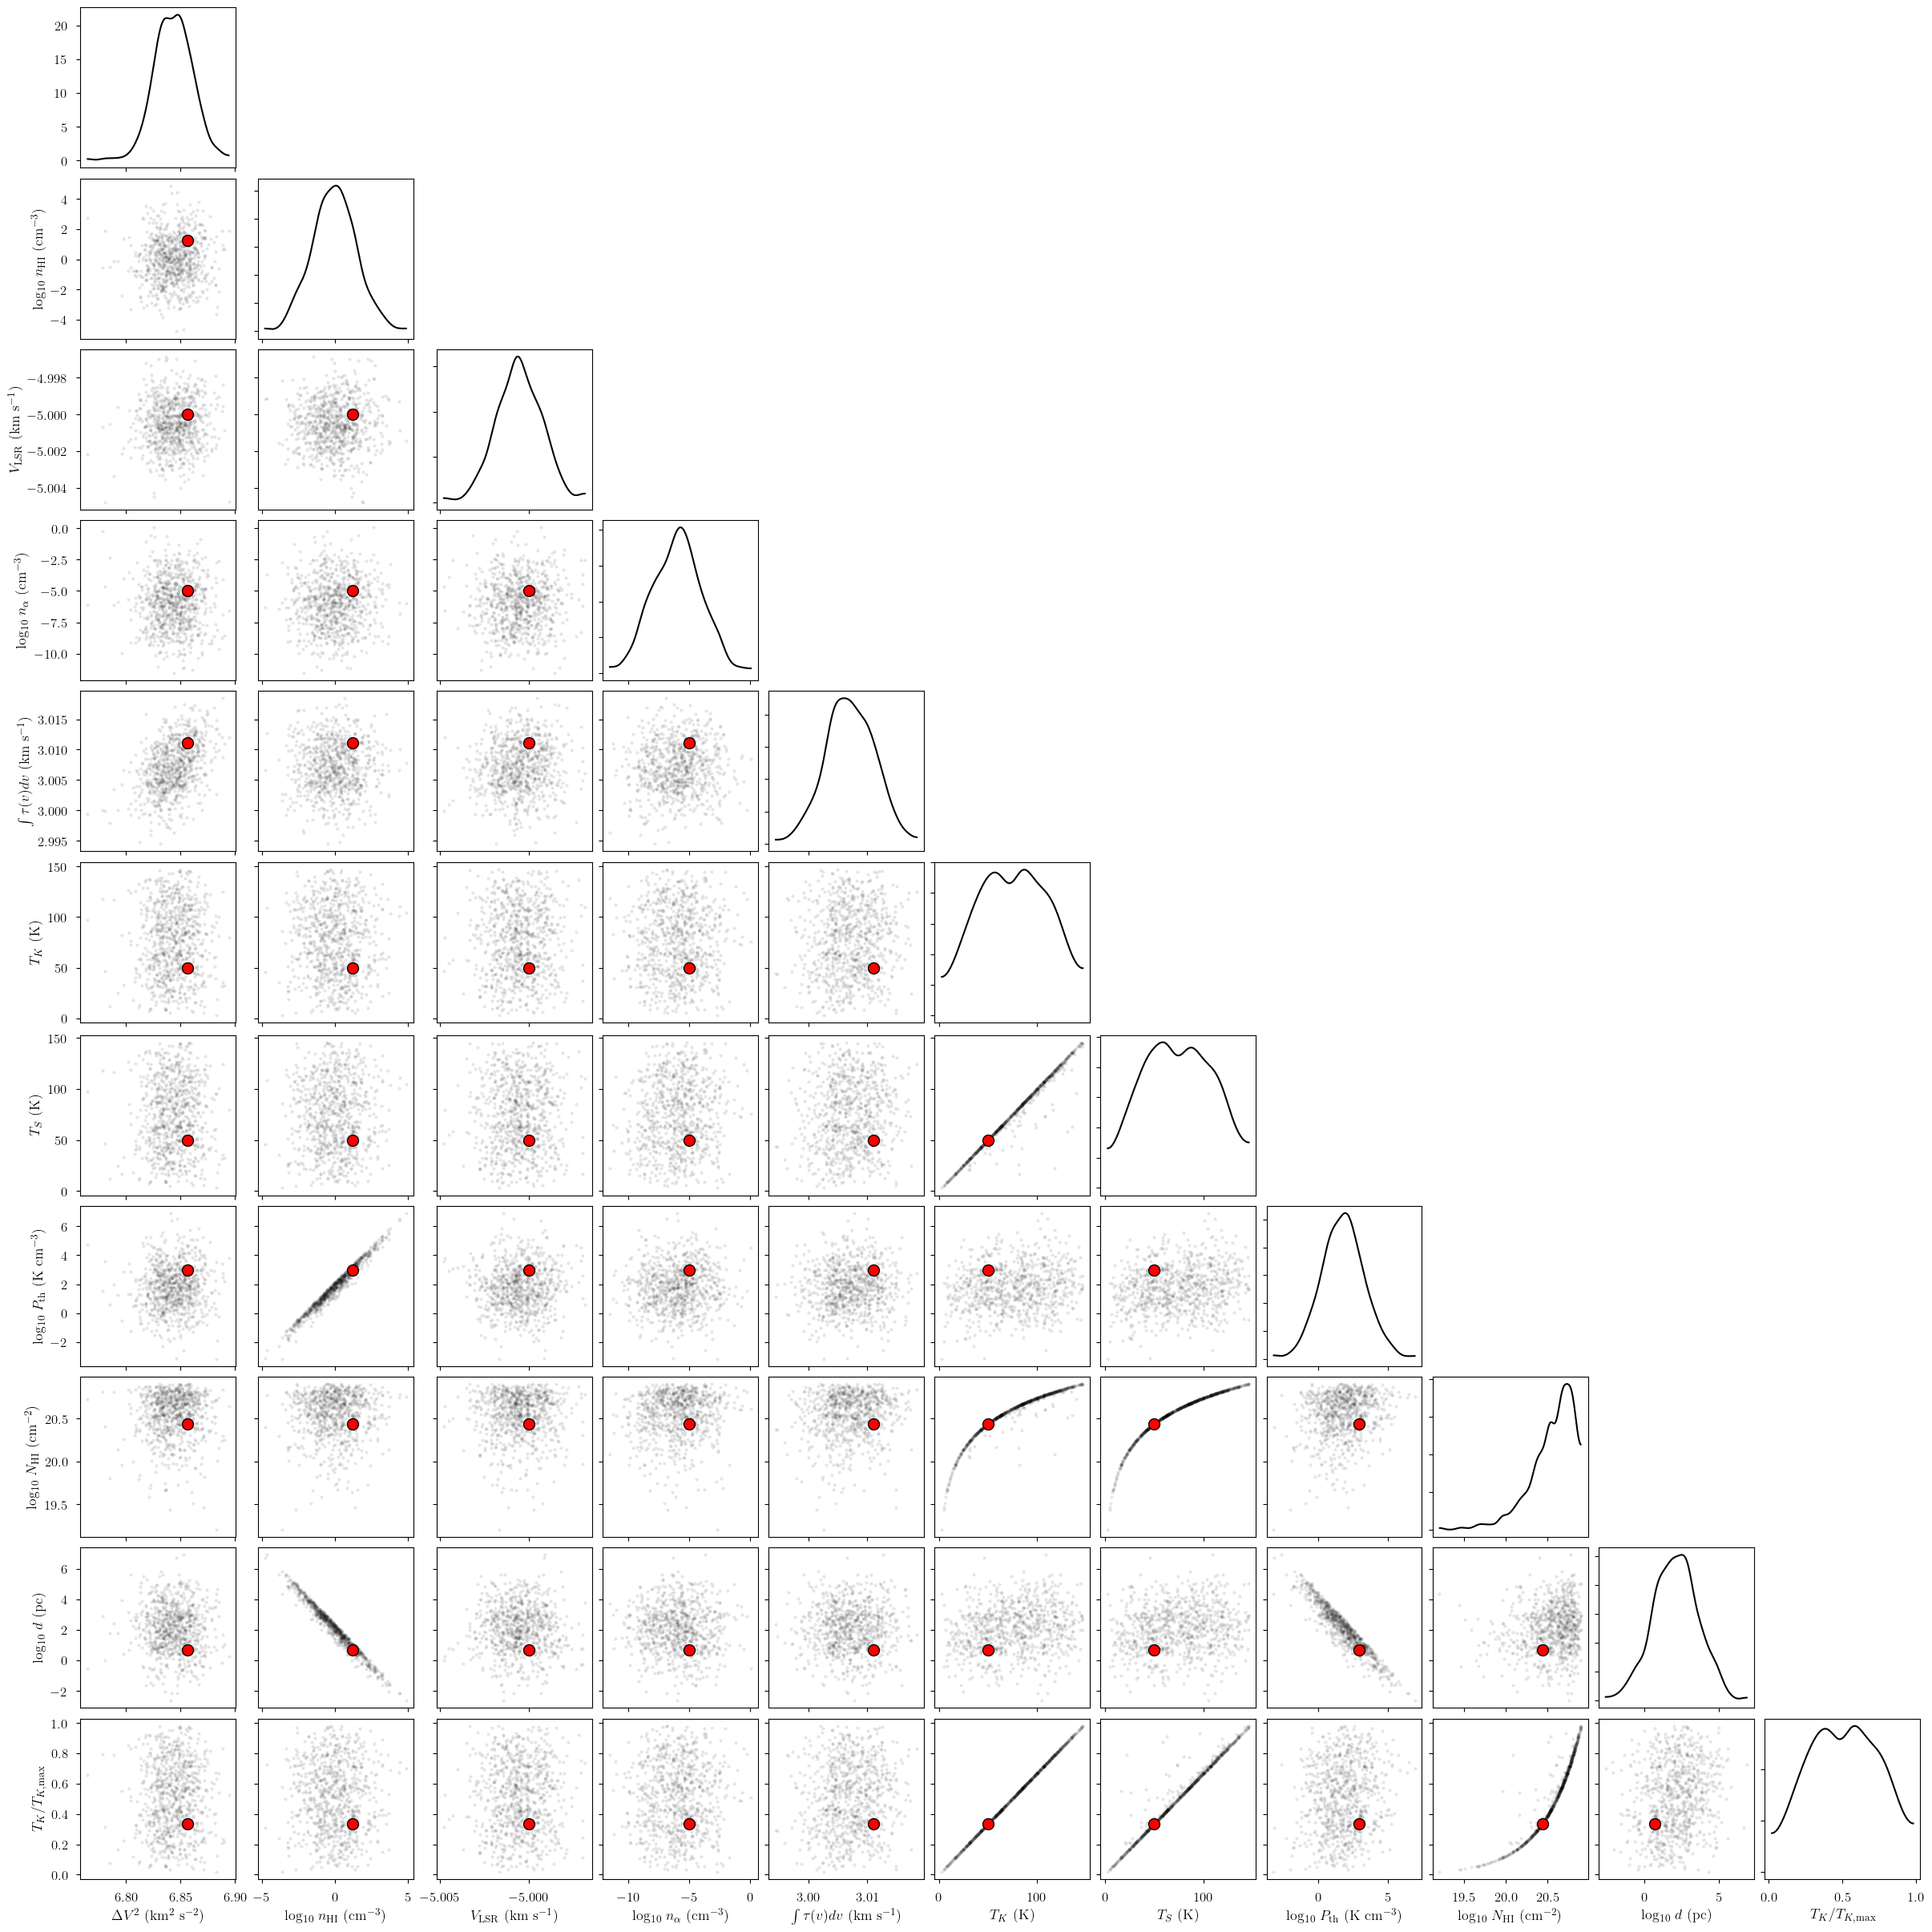

In [30]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

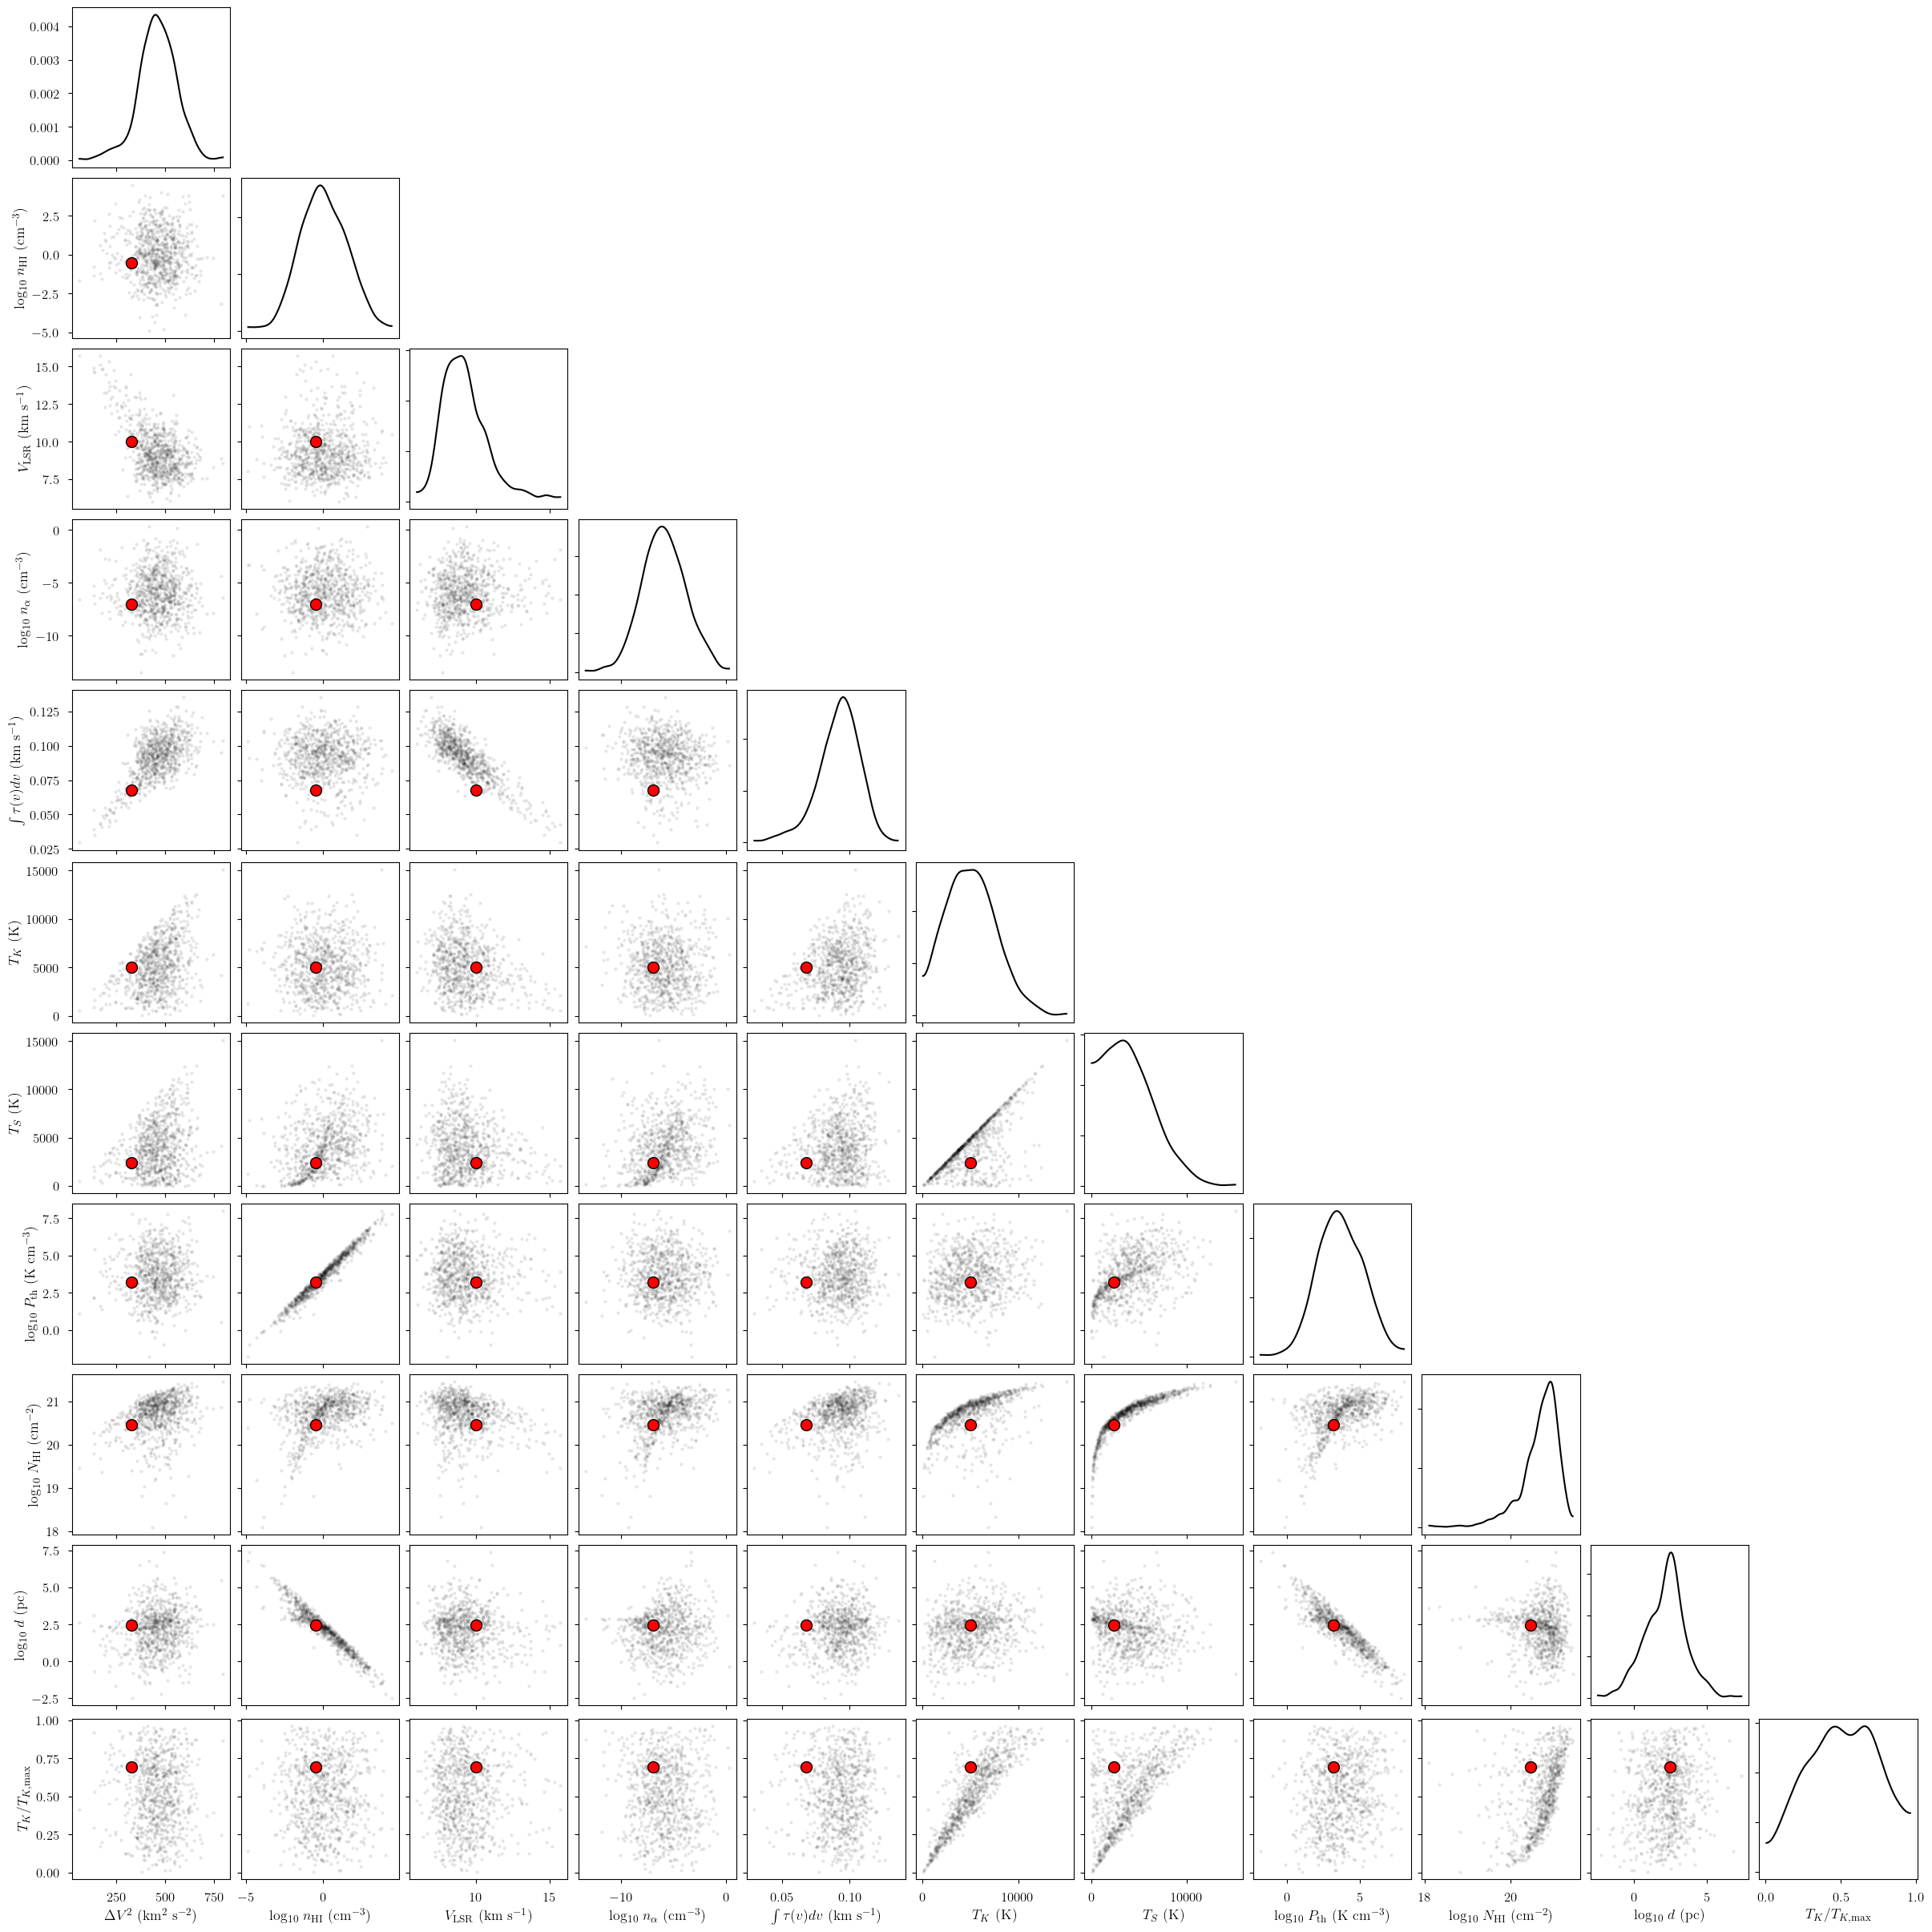

In [31]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

Finally, we can get the posterior statistics, Bayesian Information Criterion (BIC), etc.

In [32]:
point_stats = az.summary(model.trace.solution_0, kind='stats')
print("BIC:", model.bic())
display(point_stats)

BIC: -2064.1294783331787


mean        sd   hdi_3%   hdi_97%
baseline_absorption_norm[0]    -0.807     0.099   -0.998    -0.621
log10_nHI_norm[0]              -0.010     1.004   -1.922     1.832
log10_nHI_norm[1]              -0.012     1.007   -1.932     1.841
log10_nHI_norm[2]               0.023     1.019   -1.832     1.972
velocity_norm[0]                0.494     0.007    0.481     0.509
velocity_norm[1]               -0.500     0.000   -0.500    -0.500
velocity_norm[2]                0.923     0.150    0.655     1.192
log10_n_alpha_norm[0]          -0.005     0.971   -1.881     1.773
log10_n_alpha_norm[1]           0.002     1.001   -1.873     1.897
log10_n_alpha_norm[2]           0.003     1.011   -1.906     1.889
fwhm2_norm[0]                   0.077     0.006    0.066     0.089
fwhm2_norm[1]                   0.014     0.000    0.014     0.014
fwhm2_norm[2]                   0.926     0.194    0.570     1.308
tau_total_norm[0]               0.014     0.001    0.012     0.016
tau_total_norm[1]               0.301     0.000    0.300     0.302
tau_total_norm[2]               0.009     0.001    0.006     0.012
tkin_factor[0]                  0.500     0.224    0.116     0.909
tkin_factor[1]                  0.499     0.224    0.103     0.894
tkin_factor[2]                  0.505     0.224    0.099     0.893
fwhm2[0]                       38.451     3.000   33.189    44.399
fwhm2[1]                        6.843     0.017    6.810     6.875
fwhm2[2]                      462.755    97.229  284.787   654.247
log10_nHI[0]                   -0.015     1.506   -2.883     2.748
log10_nHI[1]                   -0.018     1.510   -2.898     2.761
log10_nHI[2]                    0.035     1.529   -2.747     2.958
velocity[0]                     4.945     0.073    4.814     5.087
velocity[1]                    -5.001     0.001   -5.003    -4.998
velocity[2]                     9.231     1.499    6.548    11.919
log10_n_alpha[0]               -6.010     1.942   -9.762    -2.454
log10_n_alpha[1]               -5.996     2.003   -9.746    -2.207
log10_n_alpha[2]               -5.994     2.022   -9.812    -2.222
tau_total[0]                    0.139     0.009    0.122     0.156
tau_total[1]                    3.007     0.004    3.000     3.015
tau_total[2]                    0.092     0.015    0.063     0.118
tkin[0]                       420.002   191.471   74.577   756.932
tkin[1]                        74.565    33.505   14.872   133.053
tkin[2]                      5113.685  2573.435  518.075  9556.899
tspin[0]                      394.522   189.337   45.936   716.457
tspin[1]                       72.830    33.253   14.882   132.187
tspin[2]                     4010.462  2560.091    3.973  8397.221
log10_Pth[0]                    2.546     1.530   -0.398     5.349
log10_Pth[1]                    1.794     1.530   -1.080     4.624
log10_Pth[2]                    3.672     1.562    0.776     6.612
log10_NHI[0]                   19.928     0.286   19.380    20.342
log10_NHI[1]                   20.539     0.263   20.072    20.903
log10_NHI[2]                   20.685     0.445   19.861    21.337
log10_depth[0]                  1.454     1.491   -1.367     4.273
log10_depth[1]                  2.067     1.522   -0.866     4.874
log10_depth[2]                  2.161     1.403   -0.681     4.672